----
# **Speech & Standing:**
## The Impact of Economic Fluctuations on Political Rhetoric at the United Nations General Debate
#####Elizabeth Frank


---
## **Objective**
---

The UN General Debate is a consistent venue for observing how countries articulate their priorities and frame global challenges before a worldwide audience. Because the speech topics are not negotiated texts but instead represent national preferences, they offer a unique opportunity to study the intersection of domestic conditions and international discourse. The corpus thus functions as a mirror of how governments seek to position themselves and their agendas within the evolving global order.

Economic conditions shape both the substance and tone of international rhetoric. Shifts in growth, contraction, or external shocks alter the perceived vulnerabilities and strengths of states, which then influence the framing of diplomatic content. Linking speeches to national GDP conditions allows an assessment of how economic performance corresponds with systematic differences in rhetoric priorities, and to the broader theoretical question of how upturns and downturns influence political identity in a global forum.

Beyond country level variation, global shocks create moments of collective stress that can significantly shift the agenda. Crises challenge the stability of the international system as a whole and compel states to reframe their priorities. Analyzing how shock events are reflected in the language of the General Debate, whether they elevate overarching themes or reduce the salience of persistent concerns, provides insight into the severity and impact of such events. Considered alongside country level economic conditions, this analysis offers a comprehensive view of how both structural forces and acute disruptions shape collective global political discourse.

---
## **Dataset**
---

The UN General Debate Corpus was compiled and released through the Harvard Dataverse. It contains annual speeches delivered by member states during the UN General Debate, providing one of the most comprehensive longitudinal records of international political discourse. For this project, the corpus was limited to the years 2005 through 2024 and supplemented with country names, years, and the names of individual speakers to ensure accurate alignment between speeches and speaker metadata. To maintain comparability across time and to account for variation in participation, the sample was further restricted to countries with a complete twenty year record of contributions.

To incorporate national economic context, the speeches were merged with data retrieved directly from the World Bank API. This included annual GDP per capita for each country year, along with their income group classifications.

The resulting dataset combines text, speaker information, and economic indicators to preserve the UN General Debate speeches while adding the contextual detail to evaluate how discourse varies with domestic economic performance and how it responds to periods of collective global disruption.<br><br>


Each record includes:

**ISO**: three letter ISO country code  
**Year**: year of the General Debate speech  
**Country**: name of the country delivering the speech  
**Speaker**: individual delivering the speech  
**SpeechText**: full text of the speech  
**GDP**: GDP per capita (World Bank)  
**Income_Class**: Income classification (World Bank)

---

### **Import Libraries**

In [ ]:
# Core utilities
import os
import re
import warnings
warnings.filterwarnings("ignore")

# Data handling
import pandas as pd
import numpy as np
import requests

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Sentiment
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("vader_lexicon")

# Feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS

# Modeling and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedGroupKFold
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    average_precision_score,
)

# Topic modeling (gensim)
from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel

### **Define Functions**


In [ ]:
# Function to fix garbled characters, remove artifacts, and clean up text
def clean_speech_text(text):
    try:
        # Fix mojibake: decode misinterpreted UTF-8
        text = text.encode("latin1").decode("utf-8")
    except UnicodeDecodeError:
        pass  # Use original text if decoding fails

    # Remove non-speech artifacts
    text = re.sub(r'-{2,}.*?Page\s*\d+.*?-{2,}', '', text, flags=re.IGNORECASE)
    text = re.sub(r'###?\s*Page\s*\d+.*', '', text)
    text = re.sub(r'\*\*(.*?)\*\*', r'\1', text)
    text = re.sub(r'---+', '', text)

    # Normalize whitespace and escape characters
    text = text.replace('\n', ' ')
    text = text.replace('\r', ' ')
    text = text.replace('\t', ' ')
    text = re.sub(r'\s+', ' ', text)

    return text.strip()


# Combined boxplot and histogram for numeric feature
def histogram_boxplot(df, feature, figsize=(8, 4), kde=False, bins=None):
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,
        sharex=True,
        gridspec_kw={'height_ratios': (0.25, 0.75)},
        figsize=figsize
    )
    sns.boxplot(data=df, x=feature, ax=ax_box2, showmeans=True, color='violet')
    sns.histplot(data=df, x=feature, kde=kde, ax=ax_hist2, bins=bins or 'auto')
    ax_hist2.axvline(df[feature].mean(), color='green', linestyle='--', label='Mean')
    ax_hist2.axvline(df[feature].median(), color='black', linestyle='-', label='Median')
    ax_hist2.legend()
    plt.tight_layout()
    plt.show()


# Define income group palette for consistency
income_palette = {
    "Low income": "#6baed6",
    "Lower middle income": "#74c476",
    "Upper middle income": "#fd8d3c",
    "High income": "#9e9ac8",
    "Not classified": "#fdae6b"}


# Define precision recall curve for linearSVC
def plot_pr_curve(model, X, y_true, positive_label="Downturn"):
    scores = model.decision_function(X)

    if model.named_steps['clf'].classes_[1] == positive_label:
        pos_scores = scores
    else:
        pos_scores = -scores
    y_bin = (y_true == positive_label).astype(int)

    # Precision Recall
    precision, recall, thresholds = precision_recall_curve(y_bin, pos_scores)
    avg_prec = average_precision_score(y_bin, pos_scores)

    plt.figure(figsize=(7,6))
    plt.plot(recall, precision, label=f"AP = {avg_prec:.3f}", linewidth=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision–Recall Curve ({positive_label})")
    plt.legend()
    plt.grid(True)
    plt.show()
    return precision, recall, thresholds


## Utility Functions for Preprocessing and Topic Modeling

# Clean and tokenize speeches, add bigrams, and remove stopwords/short tokens
def preprocess_docs(texts, min_len=3, min_count_bigram=10, threshold_bigram=10):
    toks = [simple_preprocess(re.sub(r"\s+", " ", t), deacc=True, min_len=min_len) for t in texts]
    bigram = Phrases(toks, min_count=min_count_bigram, threshold=threshold_bigram)
    bigram_phraser = Phraser(bigram)
    toks = [bigram_phraser[doc] for doc in toks]
    toks = [[w for w in doc if w not in STOPWORDS_LIST and len(w) > 2] for doc in toks]
    return toks


# Build dictionary and corpus with frequency cutoffs
def build_corpus(tokens, no_below=10, no_above=0.5):
    dictionary = corpora.Dictionary(tokens)
    dictionary.filter_extremes(no_below=no_below, no_above=no_above)
    corpus = [dictionary.doc2bow(t) for t in tokens]
    return dictionary, corpus


# Fit LDA models across topic numbers, evaluate coherence, and select the best model
def fit_lda_with_coherence(tokens, k_grid=(6,8,10,12), passes=10, random_state=42):
    dictionary, corpus = build_corpus(tokens)
    rows, models_by_k = [], {}
    for k in k_grid:
        lda = models.LdaModel(
            corpus=corpus, id2word=dictionary, num_topics=k,
            passes=passes, random_state=random_state, alpha="symmetric"
        )
        coh = CoherenceModel(model=lda, texts=tokens, dictionary=dictionary, coherence="c_v").get_coherence()
        rows.append((k, coh))
        models_by_k[k] = (lda, dictionary, corpus, coh)
    res = pd.DataFrame(rows, columns=["k","coherence"]).sort_values("coherence", ascending=False)
    best_k = int(res.iloc[0]["k"])
    lda, dictionary, corpus, coh = models_by_k[best_k]
    return lda, dictionary, corpus, res

# Display topics as simple, readable word lists
def print_topics_readable(lda, topn=12):
    for tid, terms in lda.show_topics(num_topics=lda.num_topics, num_words=topn, formatted=False):
        words = ", ".join(w for w, _ in terms)
        print(f"Topic {tid:02d}: {words}")


# Summarize LDA model top words, topic prevalance, label, and order
def topic_summary(lda, corpus, window_name, granular_map, broad_map=None, topn=12):
    # Top words per topic
    rows = []
    for t_id in range(lda.num_topics):
        words = [w for w,_ in lda.show_topic(t_id, topn=topn)]
        rows.append({"topic_id": t_id, "top_words": ", ".join(words)})
    df = pd.DataFrame(rows)

    # Mean prevalence per topic across docs in this window
    K = lda.num_topics
    doc_topic = np.zeros((len(corpus), K))
    for i, bow in enumerate(corpus):
        for k, p in lda.get_document_topics(bow, minimum_probability=0.0):
            doc_topic[i, k] = p
    df["mean_prevalence"] = doc_topic.mean(axis=0)

    # Attach labels
    df["granular_label"] = df["topic_id"].map(granular_map[window_name])
    if broad_map is not None:
        df["broad_category"] = df["topic_id"].map(broad_map[window_name])

    # Order by prevalence
    df = df.sort_values("mean_prevalence", ascending=False).reset_index(drop=True)
    df.insert(0, "window", window_name)
    return df


### **Import Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load dataset
un_corp = "/content/drive/MyDrive/Syracuse/IST 736 Text Mining/IST736_TextMining_UNGDC_Group Project/2005-2024 UN Corpus"

all_records = []

# Loop over sessions 60 to 79 (years 2005 to 2024)
for session_num in range(60, 80):
    session_folder = f"Session {session_num} - {2005 + (session_num - 60)}"
    folder_path = os.path.join(un_corp, session_folder)

    if not os.path.exists(folder_path):
        print(f"Skipping missing folder: {folder_path}")
        continue

    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            full_path = os.path.join(folder_path, filename)
            with open(full_path, "r", encoding="ISO-8859-1") as f:
                raw_text = f.read()
                cleaned_text = clean_speech_text(raw_text)

            # Extract metadata from filename: <ISO3>_<Session>_<Year>.txt
            name = filename.replace(".txt", "")
            try:
                iso3, session_str, year_str = name.split("_")
            except ValueError:
                print(f"Skipping malformed filename: {filename}")
                continue

            all_records.append({
                "ISO": iso3,
                "Session": int(session_str),
                "Year": int(year_str),
                "SpeechText": cleaned_text
            })

# Combine all into a DataFrame
ungdc_data = pd.DataFrame(all_records)

**Explanation:**

UN General Debate speeches are stored in session folders, each containing text files named with the country ISO code, session number, and year. Text was cleaned and all speeches were compiled into a single DataFrame.

###**Data Overview**

In [ ]:
# Preview the full song dataframe
ungdc_data.head()

,ISO,Session,Year,SpeechText
0,TGO,60,2005,"At the outset, allow me, on behalf of the peop..."
1,ZWE,60,2005,"Allow me to extend to you, Sir, our sincere co..."
2,ZMB,60,2005,I am pleased to join those who have spoken bef...
3,ZAF,60,2005,"First, I would like to salute Mr. Jean Ping, t..."
4,YUG,60,2005,"Seven days ago, from this rostrum, I warned th..."


In [ ]:
ungdc_data.tail()

,ISO,Session,Year,SpeechText
3852,LIE,79,2024,"Mr. President, ""The UN is a special meeting pl..."
3853,TUR,79,2024,"Mr. President, dear heads of states and govern..."
3854,HTI,79,2024,"Excellencies, Mr President of the General Asse..."
3855,RUS,79,2024,"Mr President, Ladies and Gentlemen, A few days..."
3856,CAN,79,2024,"Dear colleagues, It is an honour for me to spe..."


In [ ]:
pd.set_option('display.max_colwidth', None)
ungdc_data.sample(1, random_state=2)

ISO  Session  Year  \
2316  TJK       72  2017   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [ ]:
# Reset column width to default
pd.reset_option('display.max_colwidth')

In [ ]:
# Shape and columns
print("Shape:", ungdc_data.shape)
print("Columns:", ungdc_data.columns.tolist())

Shape: (3857, 4)
Columns: ['ISO', 'Session', 'Year', 'SpeechText']


**Observation:**

The original dataset has a shape of 3857 rows and 4 columns, each speech is stored as continuous prose.

####**Merge auxillary data**

In [ ]:
# Load to merge speaker data
excel_path = "/content/drive/MyDrive/Syracuse/IST 736 Text Mining/IST736_TextMining_UNGDC_Group Project/Speakers_by_session2004-2024.xlsx"

sheet1 = pd.read_excel(excel_path, sheet_name="Sheet1")
sheet4 = pd.read_excel(excel_path, sheet_name="Sheet4")

# Rename columns to match
sheet1 = sheet1.rename(columns={
    'Yr': 'Year',
    'ISO Code': 'ISO',
    'Country': 'Country',
    'Name of Person Speaking': 'Speaker'
})

sheet4 = sheet4.rename(columns={'Row Labels': 'ISO', 'Grand Total': 'Year_Count'})

# Countries with 20 years of data
full20_iso = sheet4.loc[sheet4['Year_Count'] == 20, 'ISO']
full20_iso = full20_iso[full20_iso != 'DMA']

sheet1_full20 = sheet1[sheet1['ISO'].isin(full20_iso)]

ungdc_full20 = ungdc_data[
    (ungdc_data['Year'].between(2005, 2024)) &
    (ungdc_data['ISO'].isin(full20_iso))
]

# Merge speeches with speaker and country
merged = (
    ungdc_full20
    .merge(sheet1_full20[['ISO', 'Year', 'Country', 'Speaker']], on=['ISO', 'Year'], how='inner')
    .drop_duplicates(subset=['ISO', 'Year'])
    .reset_index(drop=True)
)

In [ ]:
# Fetch World Bank API
def wb_fetch_indicator(indicator, date_range="2005:2024"):
    url = f"https://api.worldbank.org/v2/country/all/indicator/{indicator}"
    params = {"format": "json", "per_page": 20000, "date": date_range}
    r = requests.get(url, params=params)
    r.raise_for_status()
    data = r.json()
    rows = data[1]
    df = pd.DataFrame(rows)

    # Keep only country rows
    df = df[df["countryiso3code"].str.len() == 3]
    out = df[["countryiso3code", "date", "value"]].rename(
        columns={"countryiso3code": "ISO", "date": "Year", "value": "GDP_pc_const"}
    )
    out["Year"] = out["Year"].astype(int)
    return out

def wb_fetch_countries():
    url = "https://api.worldbank.org/v2/country"
    params = {"format": "json", "per_page": 4000}
    r = requests.get(url, params=params)
    r.raise_for_status()
    data = r.json()[1]
    df = pd.DataFrame(data)

    # Keep only with ISO codes
    df = df[df["id"].str.len() == 3]
    keep = df[["id", "name", "region", "incomeLevel"]].copy()
    keep["ISO"] = keep["id"]
    keep["WB_Country_Name"] = keep["name"]
    keep["WB_Income_ID"] = keep["incomeLevel"].apply(lambda x: x.get("id") if isinstance(x, dict) else None)
    keep["WB_Income_Name"] = keep["incomeLevel"].apply(lambda x: x.get("value") if isinstance(x, dict) else None)
    keep["WB_Region_Name"] = keep["region"].apply(lambda x: x.get("value") if isinstance(x, dict) else None)
    return keep[["ISO", "WB_Country_Name", "WB_Income_ID", "WB_Income_Name", "WB_Region_Name"]]

# Fetch data
gdp_pc = wb_fetch_indicator("NY.GDP.PCAP.KD", "2005:2024")
countries_meta = wb_fetch_countries()

# Clean and merge
merged["ISO"] = merged["ISO"].astype(str).str.strip().str.upper()
merged["Year"] = pd.to_numeric(merged["Year"], errors="coerce").astype("Int64")

ungdc_use = merged[merged["Year"].between(2005, 2024)].copy()

# Merge GDP and income group
ungdc_enriched = ungdc_use.merge(gdp_pc, on=["ISO","Year"], how="left")
ungdc_enriched = ungdc_enriched.merge(countries_meta, on="ISO", how="left")

# Select and rename columns
ungdc_enriched_data = ungdc_enriched[['ISO', 'Year', 'Country', 'Speaker', 'SpeechText',
    'GDP_pc_const', 'WB_Income_Name']].rename(columns={'GDP_pc_const': 'GDP','WB_Income_Name': 'Income_Class'})

**Explanation:**

Speeches from the UNGD were merged with World Bank GDP and World Bank income group classifications by using country ISO codes and years as keys.  

In [ ]:
# Make a copy
ungdc_df = ungdc_enriched_data.copy()

In [ ]:
ungdc_df.head()

,ISO,Year,Country,Speaker,SpeechText,GDP,Income_Class
0,TGO,2005,Togo,Zarifou Ayeva,"At the outset, allow me, on behalf of the peop...",630.248628,Low income
1,ZWE,2005,Zimbabwe,Robert Gabriel Mugabe,"Allow me to extend to you, Sir, our sincere co...",1088.076995,Lower middle income
2,ZMB,2005,Zambia,Levy Patrick Mwanawasa,I am pleased to join those who have spoken bef...,929.079256,Lower middle income
3,YEM,2005,Yemen,"Abdullah Alsaidi,",The Government of the Republic of Yemen believ...,2237.616415,Low income
4,WSM,2005,Samoa,Tuilaepa Sailele Malielegaoi,"Samoa warmly congratulates you, Sir, on your e...",3755.782428,Upper middle income


In [ ]:
ungdc_df.shape

(3340, 7)

**Observation:**

The complete dataset contains 3,340 speeches with 7 variables: ISO code, year, country, speaker, full text, GDP per capita, and income classification.  

####**Missing Values**

In [ ]:
# Missing counts and percentages for GDP and Income_Class
cols_to_check = ['GDP', 'Income_Class']
for col in cols_to_check:
    missing_count = ungdc_df[col].isna().sum()
    missing_percent = (missing_count / len(ungdc_df)) * 100
    print(f"{col}: {missing_count} missing ({missing_percent:.2f}%)")


GDP: 83 missing (2.49%)
Income_Class: 20 missing (0.60%)


In [ ]:
# Countries missing GDP
missing_gdp_iso = (
    ungdc_df[ungdc_df['GDP'].isna()]
    .groupby('ISO')
    .size()
    .reset_index(name='Missing_GDP_Years')
    .sort_values('Missing_GDP_Years', ascending=False)
)

# Countries missing Income_Class
missing_income_iso = (
    ungdc_df[ungdc_df['Income_Class'].isna()]
    .groupby('ISO')
    .size()
    .reset_index(name='Missing_Income_Years')
    .sort_values('Missing_Income_Years', ascending=False)
)

print("Missing GDP by ISO ")
display(missing_gdp_iso)

print("\nMissing Income_Class by ISO")
display(missing_income_iso)


Missing GDP by ISO 


,ISO,Missing_GDP_Years
12,VAT,20
13,VEN,20
5,LIE,19
2,ERI,13
8,SMR,2
0,BTN,1
1,CUB,1
3,KOR,1
4,LBN,1
6,MCO,1



Missing Income_Class by ISO


,ISO,Missing_Income_Years
0,VAT,20


In [ ]:
# Drop countries with the majority of missing data
drop_iso = ['VEN', 'VAT', 'LIE', 'ERI']
ungdc_df = ungdc_df[~ungdc_df['ISO'].isin(drop_iso)]

# Impute missing GDP with median GDP for that ISO across available years
ungdc_df['GDP'] = ungdc_df.groupby('ISO')['GDP'].transform(
    lambda x: x.fillna(x.median())
)

# Impute missing Income_Class with the mode for that ISO
ungdc_df['Income_Class'] = ungdc_df.groupby('ISO')['Income_Class'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else None)
)
ungdc_df = ungdc_df.reset_index(drop=True)

# Missing value check
print("Missing GDP:", ungdc_df['GDP'].isna().sum())
print("Missing Income_Class:", ungdc_df['Income_Class'].isna().sum())

Missing GDP: 0
Missing Income_Class: 0


In [ ]:
ungdc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3260 entries, 0 to 3259
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ISO           3260 non-null   object 
 1   Year          3260 non-null   Int64  
 2   Country       3260 non-null   object 
 3   Speaker       3260 non-null   object 
 4   SpeechText    3260 non-null   object 
 5   GDP           3260 non-null   float64
 6   Income_Class  3260 non-null   object 
dtypes: Int64(1), float64(1), object(5)
memory usage: 181.6+ KB


**Observation:**

Missing values were concentrated in a small group of countries, most notably Venezuela, the Vatican, Liechtenstein, and Eritrea, which showed systematic gaps and were dropped. Remaining cases with isolated gaps, GDP was imputed using the country median across available years and income class was imputed using the country mode. After these steps, no missing values remained for either GDP or income classification, with the dataset containing 3,260 observations.

### **Exploratory Data Anaylsis**

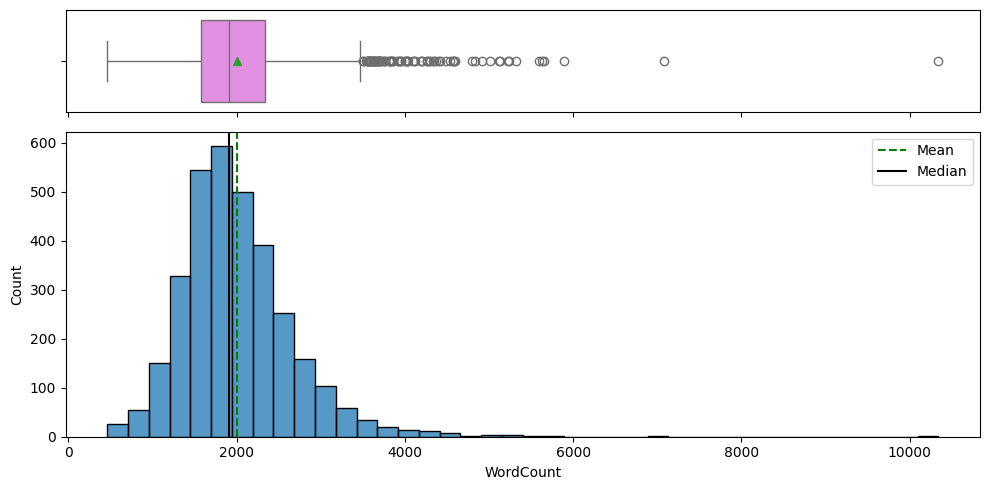

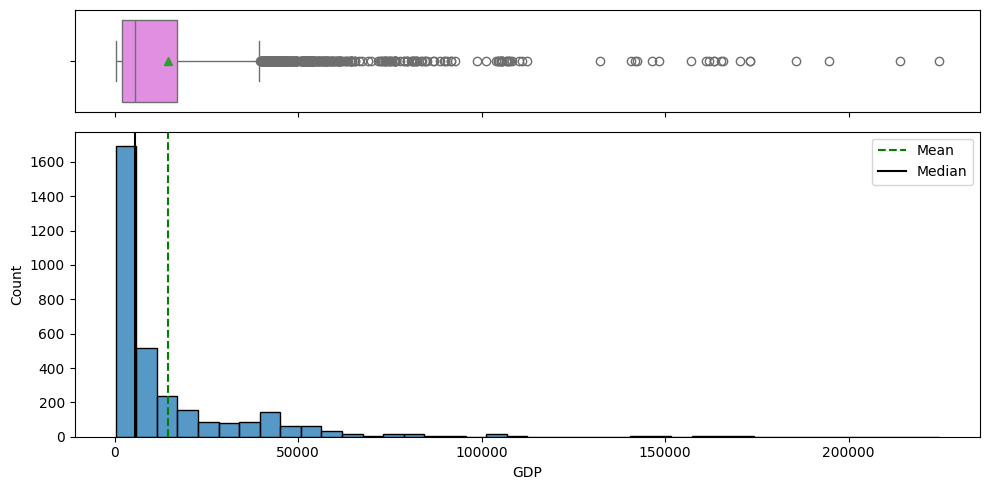

In [ ]:
# Distribution of wordcound and GDP
ungdc_df['WordCount'] = ungdc_df['SpeechText'].str.split().str.len()

histogram_boxplot(ungdc_df, feature='WordCount', figsize=(10, 5), kde=False, bins=40)
histogram_boxplot(ungdc_df, feature='GDP', figsize=(10,5), kde=False, bins=40)

**Observation:**

Word counts cluster around a central range of 1500 to 2500 words with a right tail of longer speeches, relatively consistent length across most countries with an occasional extended prose. GDP per capita is highly skewed, with the majority of values concentrated under 20,000 dollars and a long right tail extending beyond 100,000 dollars, reflecting the disparity between low-income states and very wealthy outliers. In both cases the mean is pulled upward by extreme values, while the median provides a more representative measure of central tendency.

####**Speech Length Characteristics**

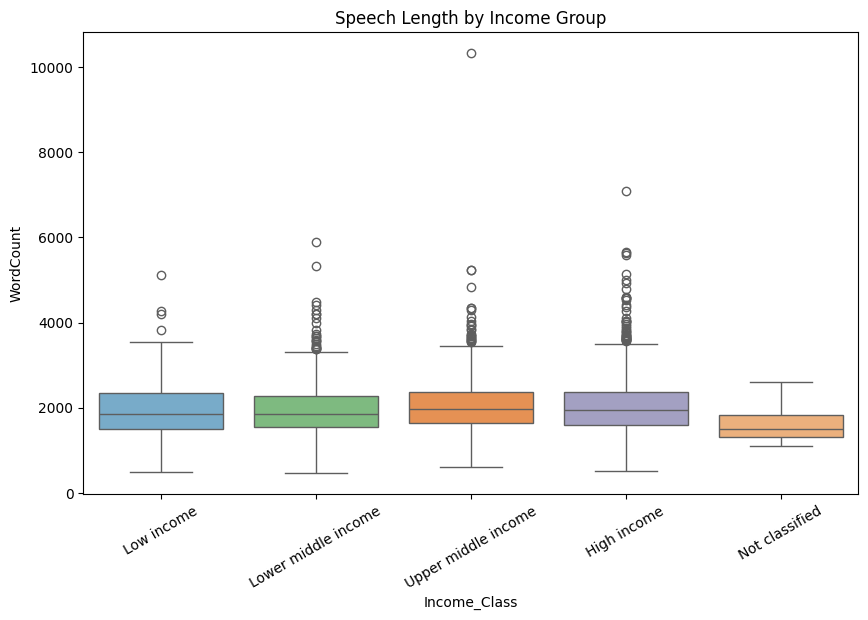

In [ ]:
# Speech length by income group
plt.figure(figsize=(10,6))
sns.boxplot(data=ungdc_df, x='Income_Class', y='WordCount', palette=income_palette)
plt.title("Speech Length by Income Group")
plt.xticks(rotation=30)
plt.show()

**Observation:**

Speech length is fairly consistent across income groups, with medians around 1700 to 2000 words. All groups display wide variation and some long outliers, although high income and upper middle income countries show slightly higher upper ranges.

In [ ]:
# Exploring "Not classified"
not_classified = ungdc_df[ungdc_df['Income_Class'].isna() | (ungdc_df['Income_Class'] == 'Not classified')]

# Unique countries and their counts
not_classified_summary = (
    not_classified.groupby('ISO')
    .agg(Country=('Country','first'),
         NumSpeeches=('SpeechText','count'),
         Years=('Year', lambda x: sorted(x.unique())))
    .reset_index()
)

not_classified_summary

,ISO,Country,NumSpeeches,Years
0,ETH,Ethiopia,20,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201..."


In [ ]:
# Manual patch for Ethiopia
ungdc_df.loc[ungdc_df['ISO'] == 'ETH', 'Income_Class'] = 'Low income'

**Explanation:**

Not classified income group is comprised of only Ethiopia, with all twenty years of speeches labeled as missing or unclassified. Because Ethiopia is consistently categorized as low income in World Bank data, the records were manually reassigned to the Low income category.

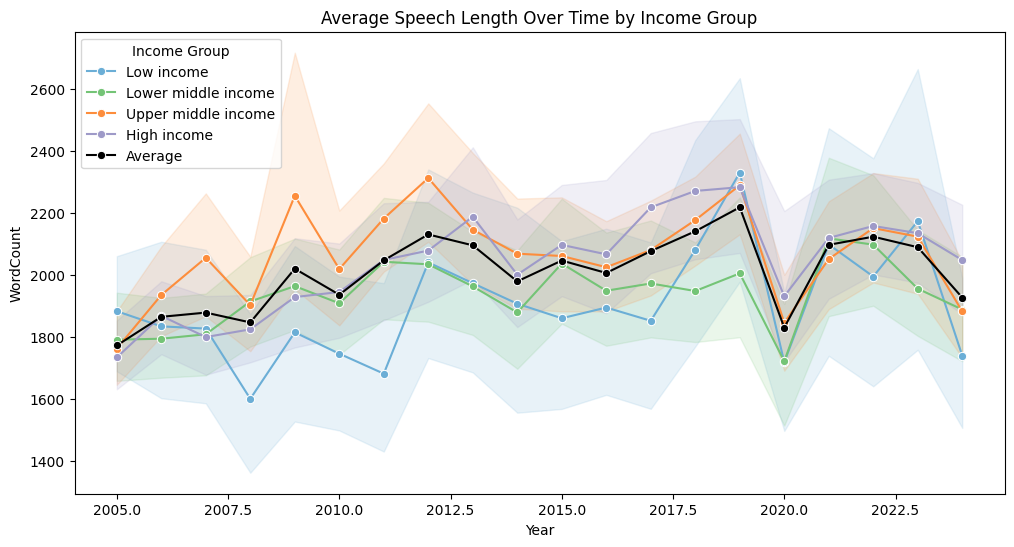

In [ ]:
# Average speech length over time period by income group
plt.figure(figsize=(12,6))

# Income class
sns.lineplot(data=ungdc_df, x='Year', y='WordCount', hue='Income_Class', palette=income_palette,
    estimator='mean', marker='o', errorbar="ci", err_kws={'alpha':0.15})

# Overall average
sns.lineplot(data=ungdc_df, x='Year', y='WordCount',color='black',estimator='mean', marker='o',
    label='Average', errorbar=None)

plt.title("Average Speech Length Over Time by Income Group")
plt.legend(title="Income Group")
plt.show()

**Observation:**

Speech length shows a gradual upward trend across all income groups through the late 2010s, with upper middle and high income countries generally delivering longer speeches than low and lower middle income countries. A sharp decline appears in 2020 during the COVID-19 pandemic. While the absolute lengths differ, the overall pattern is consistent across income categories, suggesting shared temporal dynamics with variation mainly in degree rather than direction.

###**Unique Speakers for each Country**

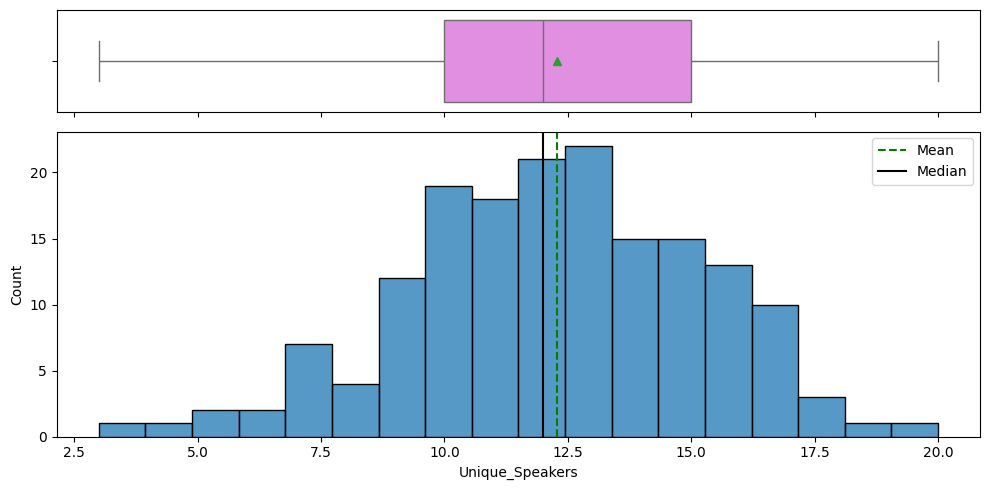

In [ ]:
# Unique speaker distribution
speaker_counts = (
    merged.assign(Speaker=merged['Speaker'].str.strip().str.lower())
          .groupby('ISO', as_index=False)
          .agg(Unique_Speakers=('Speaker', 'nunique'))
)

histogram_boxplot(speaker_counts, feature='Unique_Speakers', figsize=(10,5), kde=False, bins=18)

In [ ]:
# Countries with the most and least unique speakers
country_names = (merged[['ISO', 'Country']].drop_duplicates(subset=['ISO']))
speaker_counts_named = speaker_counts.merge(country_names, on='ISO', how='left')

top_turnover = speaker_counts_named.sort_values('Unique_Speakers', ascending=False).head(10)
most_stable = speaker_counts_named.sort_values('Unique_Speakers', ascending=True).head(10)

print("Top 10:\n", top_turnover[['ISO','Country','Unique_Speakers']])
print("\nLowest:\n", most_stable[['ISO','Country','Unique_Speakers']])

Top 10:
      ISO       Country  Unique_Speakers
114  NPL         Nepal               20
27   CHE   Switzerland               19
0    AGO        Angola               18
58   GIN        Guinea               18
124  PRY      Paraguay               18
13   BFA  Burkina Faso               17
105  MRT    Mauritania               17
108  MYS      Malaysia               17
119  PER         Peru                17
88   LBY         Libya               17

Lowest:
      ISO                           Country  Unique_Speakers
125  PSE                         Palestine                3
129  RWA                            Rwanda                4
94   LUX                        Luxembourg                5
14   BGD                        Bangladesh                5
159  VCT  Saint Vincent and the Grenadines                6
142  SYR                             Syria                6
38   CYP                            Cyprus                7
82   KIR                          Kiribati                7
7

**Observation:**

The distribution of unique speakers per country centers around 12 to 13, with most countries falling in a middle range between 10 and 15 speakers. A few cases stand out at both extremes: Nepal recorded the maximum possible with 20 unique speakers, while Palestine had only 3. Countries such as Switzerland, Angola, and Guinea also had high turnover, whereas Luxembourg, Rwanda, and Syria had far fewer changes. Overall, the variation highlights differences in political stability, leadership transitions, and representation practices across member states.

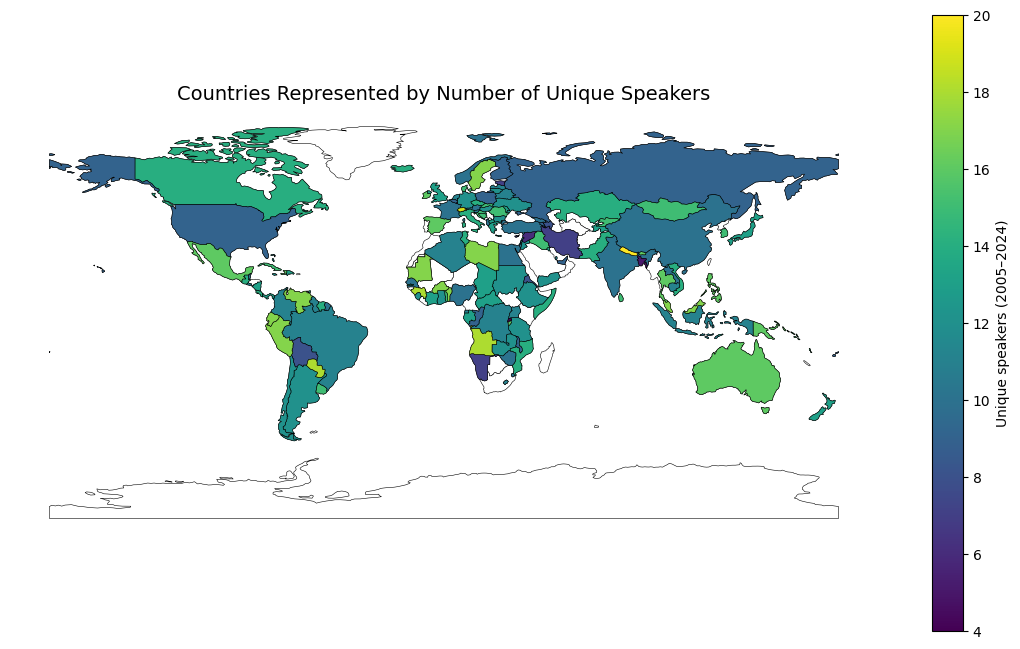

In [ ]:
# World shapefile
url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(f"zip+{url}")

# Sync ISO codes
speaker_counts['ISO'] = speaker_counts['ISO'].str.upper().str.strip()
world['ADM0_A3'] = world['ADM0_A3'].str.upper().str.strip()

# Merge with world map
world_subset = world.merge(speaker_counts[['ISO', 'Unique_Speakers']], left_on='ADM0_A3',
    right_on='ISO', how='inner')

fig, ax = plt.subplots(figsize=(14, 8))
world.plot(ax=ax, color='white', edgecolor='black', linewidth=0.4)

# Overlay dataset countries filled by number of unique speakers
world_subset.plot(column='Unique_Speakers', ax=ax, cmap='viridis', legend=True,
    legend_kwds={'label': 'Unique speakers (2005–2024)'}, edgecolor='black', linewidth=0.4)

ax.set_title('Countries Represented by Number of Unique Speakers', fontsize=14)
ax.axis('off')
plt.show()

**Observation:**

The geographic distribution of unique speakers shows that much of Africa and parts of South Asia have a higher turnover in representation, while countries across Europe, North America, and the Middle East often had fewer individuals speaking. Latin America and the Pacific present a mixed pattern, with some states rotating speakers frequently and others showing continuity.

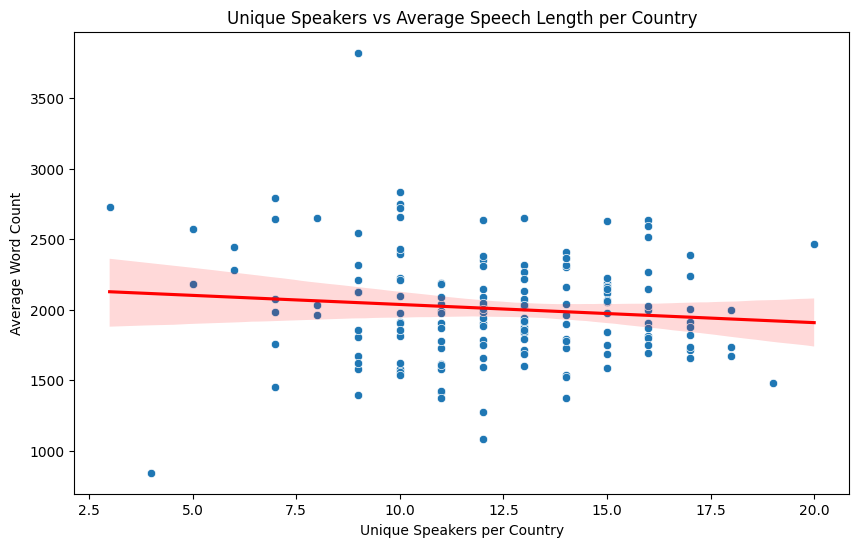

In [ ]:
# Average speech length per country by unique speakers
avg_wordcount = ungdc_df.groupby('ISO')['WordCount'].mean().reset_index()
speakers_wc = speaker_counts.merge(avg_wordcount, on='ISO')

plt.figure(figsize=(10,6))
sns.scatterplot(data=speakers_wc, x='Unique_Speakers', y='WordCount')
sns.regplot(data=speakers_wc, x='Unique_Speakers', y='WordCount', scatter=False, color='red')
plt.title("Unique Speakers vs Average Speech Length per Country")
plt.xlabel("Unique Speakers per Country")
plt.ylabel("Average Word Count")
plt.show()

In [ ]:
# Correlation between speaker turnover and average speech length
corr = speakers_wc[['Unique_Speakers','WordCount']].corr().iloc[0,1]
print(f"Correlation: {corr:.2f}")

Correlation: -0.11


**Observation:**

The relationship between the number of unique speakers and average speech length is weak and slightly negative, with a correlation of -0.11. Countries with higher turnover in representation tend to give marginally shorter speeches on average, but the effect is minimal and the overall pattern remains widely dispersed.

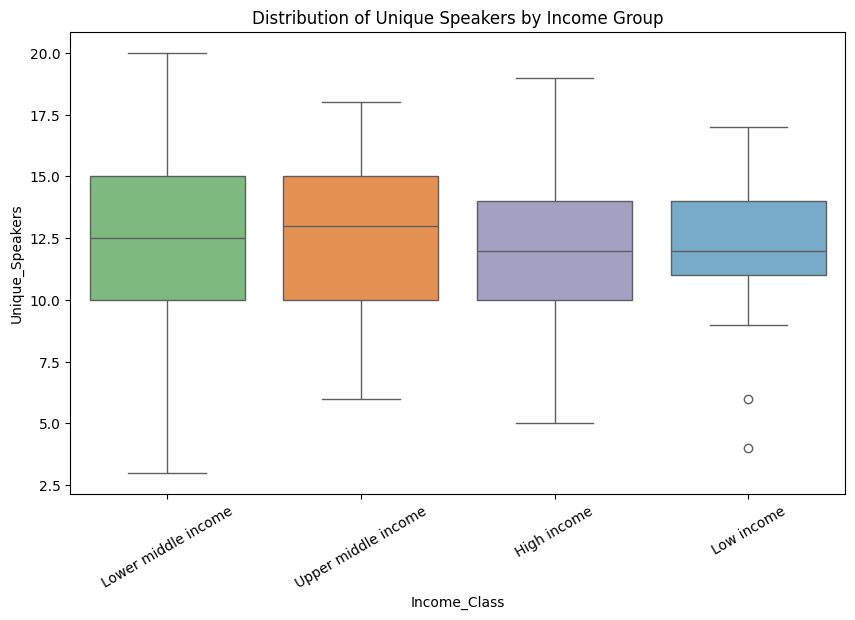

In [ ]:
# Distribution of speakers by income group
income_classes = (ungdc_df.groupby('ISO')['Income_Class']
    .agg(lambda x: x.mode()[0] if not x.mode().empty else None).reset_index())
speaker_counts_named = speaker_counts_named.merge(income_classes, on='ISO', how='left')

plt.figure(figsize=(10,6))
sns.boxplot(data=speaker_counts_named, x='Income_Class', y='Unique_Speakers', palette=income_palette)
plt.title("Distribution of Unique Speakers by Income Group")
plt.xticks(rotation=30)
plt.show()

**Observation:**

The distribution of unique speakers is similar across income groups, with medians clustered around 12 to 13. Lower and upper middle income countries display the widest spread, indicating greater variation in leadership turnover, while high income and low income groups are more tightly concentrated. A few low income cases fall well below the main distribution, reflecting countries with unusually stable or maybe restricted representation.

###**GDP Characteristics**

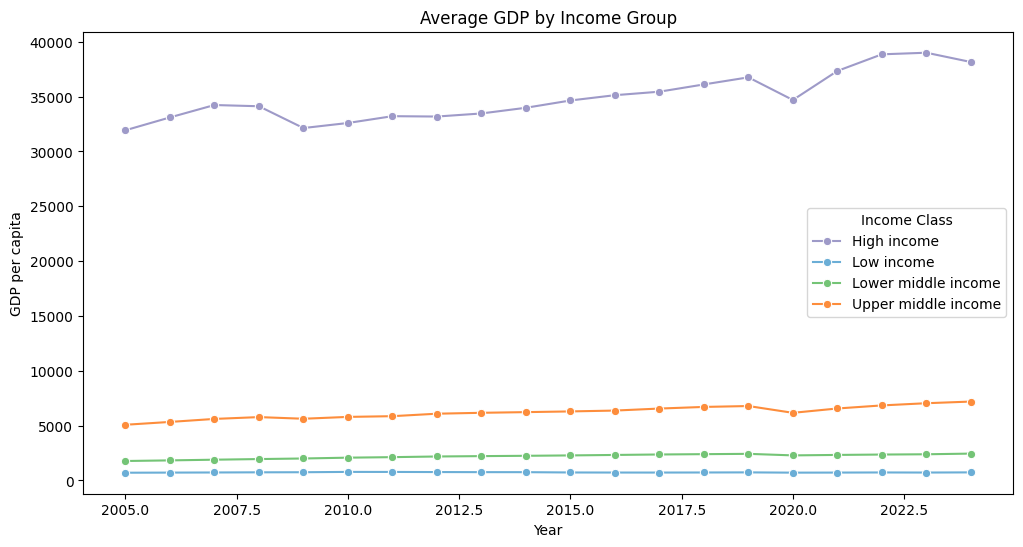

In [ ]:
# Average GDP per capita by income group classifications
gdp_trends = ungdc_df.groupby(['Year','Income_Class'])['GDP'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=gdp_trends, x='Year', y='GDP', hue='Income_Class', palette=income_palette, marker='o')
plt.title("Average GDP by Income Group")
plt.ylabel("GDP per capita")
plt.legend(title="Income Class")
plt.show()

**Observation:**

Average GDP clearly separates the four income groups, with high income countries consistently far above the others and a growth trend across the period. Upper middle income countries maintain a rising trajectory, lower middle and low income groups remain clustered at much lower levels with modest gains. The divergence between groups highlights persistent global inequality in economic capacity.

###**VADER Sentiment**

In [ ]:
# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()
ungdc_df['Sentiment'] = ungdc_df['SpeechText'].apply(lambda x: sia.polarity_scores(x)['compound'])

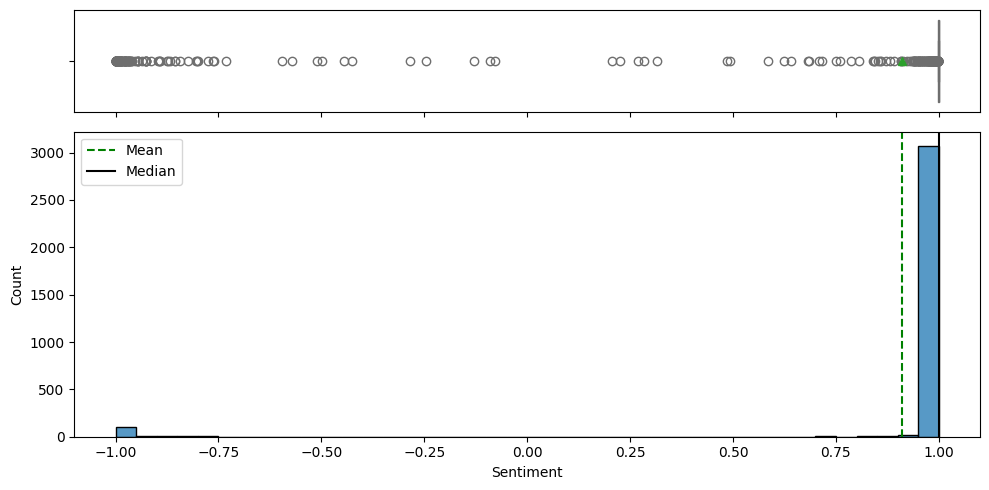

In [ ]:
# Sentiment distribution
histogram_boxplot(ungdc_df, feature='Sentiment', figsize=(10,5), kde=False, bins=40)

**Observation:**

Sentiment scores are overwhelmingly concentrated near +1 on the VADER compound scale. The distribution is highly skewed, showing only a small number of negative outliers. This pattern reflects the formal and diplomatic nature of UN General Debate speeches, which are framed to emphasize cooperation, solidarity, and positive aspirations even when addressing conflict or crisis, leading the lexicon based model to classify them as strongly positive.

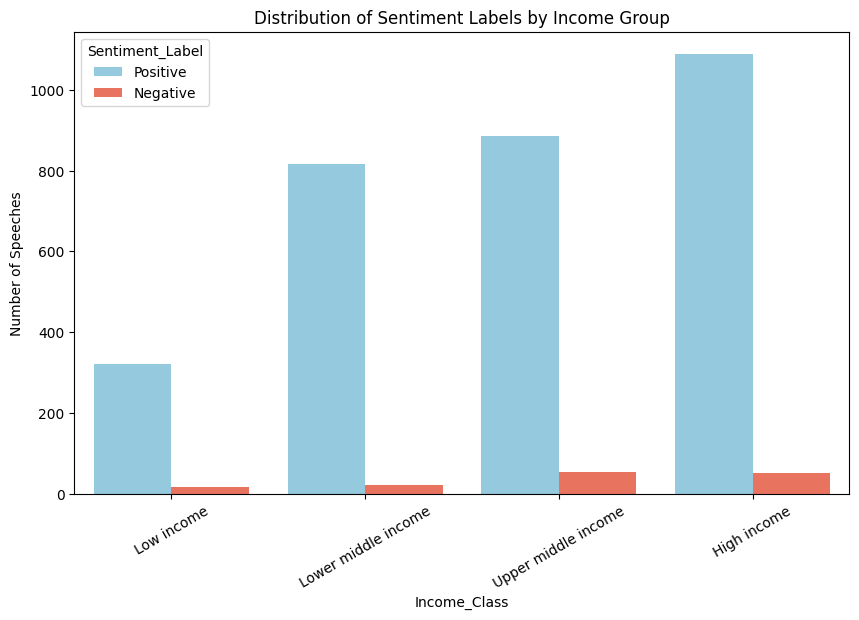

In [ ]:
# Define sentiment labels
def sentiment_label(score):
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

ungdc_df['Sentiment_Label'] = ungdc_df['Sentiment'].apply(sentiment_label)

plt.figure(figsize=(10,6))
sns.countplot(data=ungdc_df, x='Income_Class', hue='Sentiment_Label',
    palette={'Positive':'skyblue','Neutral':'tan','Negative':'tomato'})
plt.title("Distribution of Sentiment Labels by Income Group")
plt.xticks(rotation=30)
plt.ylabel("Number of Speeches")
plt.show()

**Observation:**

Across all income groups the vast majority of speeches are labeled positive, with only a small minority labeled as negative. High income countries contribute the largest number of speeches overall, then upper and lower middle income groups, and low income countries account for fewer speeches in total. The imbalance reflects both the formal style of UN discourse and VADER's tendency to classify diplomatic language as positive.

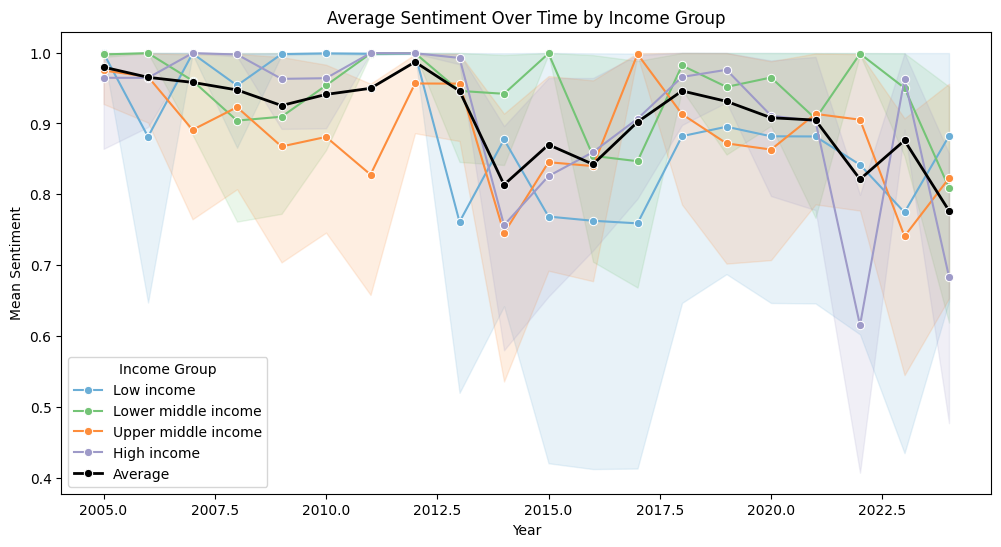

In [ ]:
# Confidence interval income group and overall average sentiment
plt.figure(figsize=(12,6))

sns.lineplot(data=ungdc_df, x='Year', y='Sentiment', hue='Income_Class', palette=income_palette,
    marker='o', errorbar="ci", err_kws={'alpha':0.15})
sns.lineplot(data=ungdc_df, x='Year', y='Sentiment', color='black', estimator='mean', marker='o',
    label='Average', errorbar=None, linewidth=2)

plt.title("Average Sentiment Over Time by Income Group")
plt.ylabel("Mean Sentiment")
plt.legend(title="Income Group")
plt.show()

**Observation:**

Sentiment trends are clustered across income groups, with scores close to the upper limit of the scale. Small downturns appear at several points, but no group departs significantly from the overall pattern. The uniformity reinforces how strongly diplomatic language converges regardless of economic classification.

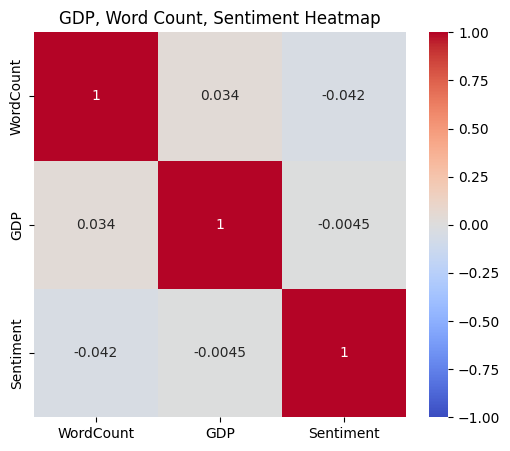

In [ ]:
# GDP, word count, sentiment heatmap
num_vars = ungdc_df[['WordCount','GDP','Sentiment']].copy()
corr = num_vars.corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, center=0)
plt.title("GDP, Word Count, Sentiment Heatmap")
plt.show()

**Observation:**

Correlations among word count, GDP per capita, and sentiment are weak, all coefficients are close to zero. Speech length shows no systematic association with either economic status or sentiment, and sentiment itself is essentially independent of GDP. This indicates that neither a country's income level nor the length of its speech meaningfully predicts the tone captured by VADER.

In [ ]:
# Average sentiment by country
avg = (ungdc_df.groupby("Country", as_index=False)["Sentiment"].mean())

# Top 10
top10 = (avg.nlargest(10, "Sentiment").sort_values("Sentiment", ascending=False)
       .assign(Group="Top 10").reset_index(drop=True))
top10["Rank"] = range(1, len(top10)+1)

# Bottom 10
bottom10 = (avg.nsmallest(10, "Sentiment").sort_values("Sentiment", ascending=False)
       .assign(Group="Bottom 10").reset_index(drop=True))
bottom10["Rank"] = range(1, len(bottom10)+1)

sentiment_rank_df = pd.concat([top10, bottom10], ignore_index=True)[["Rank", "Country", "Sentiment"]]
sentiment_rank_df["Sentiment"] = sentiment_rank_df["Sentiment"].round(3)
sentiment_rank_df

,Rank,Country,Sentiment
0,1,Republic of the Gambia,1.000
1,2,United States,1.000
2,3,China,1.000
3,4,Bhutan,1.000
4,5,Burundi,1.000
5,6,Commonwealth of Australia,1.000
6,7,Côte d'Ivoire,1.000
7,8,Eastern Republic of Uruguay,1.000
8,9,Federal Democratic Republic of Nepal,1.000
9,10,Georgia,1.000


**Observation:**

The rankings show extreme VADER scores in UNG many countries, including the United States, China, and Australia, receive the maximum possible sentiment value of +1, indicating the increased positive framing. At the opposite end, a handful of states such as Syria, Cuba, and Pakistan are scored near -1, likely occurring from recurrent language around conflict, sanctions, or confrontation. The polarization highlights the limitations of applying a lexicon based tool directly to political speeches, where expressions of cooperation push scores upward while repeated references to violence or crisis drive them downward.

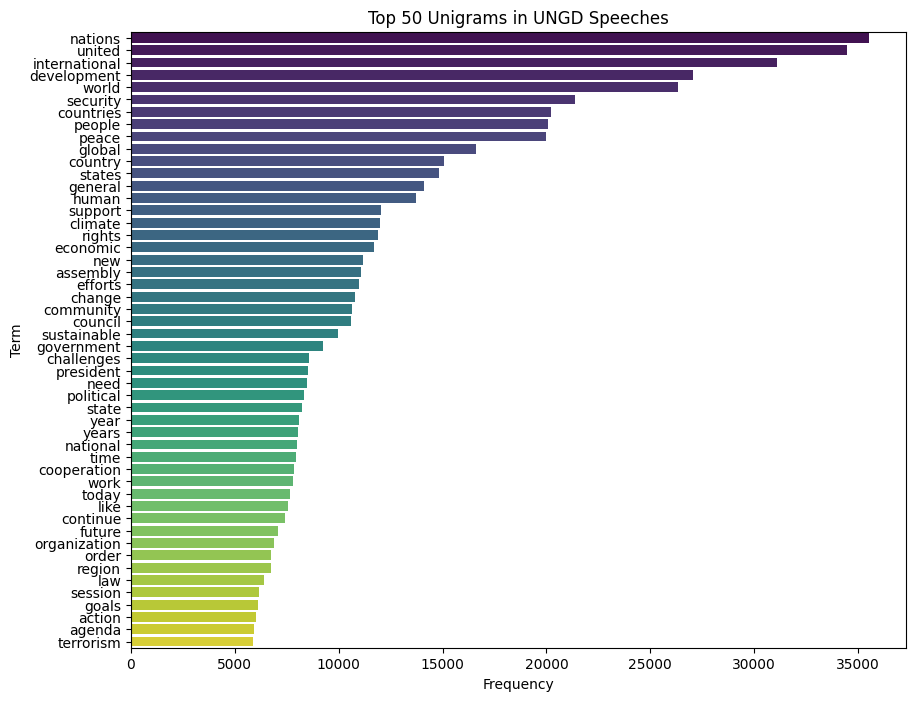

In [ ]:
# Top unigrams in the UNGD
vectorizer = CountVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(ungdc_df['SpeechText'])

word_counts = X.toarray().sum(axis=0)
vocab = vectorizer.get_feature_names_out()
freq_df = pd.DataFrame({'term': vocab, 'count': word_counts})
top50 = freq_df.sort_values(by='count', ascending=False).head(50)

plt.figure(figsize=(10,8))
sns.barplot(data=top50, y='term', x='count', palette="viridis")
plt.title("Top 50 Unigrams in UNGD Speeches")
plt.xlabel("Frequency")
plt.ylabel("Term")
plt.show()

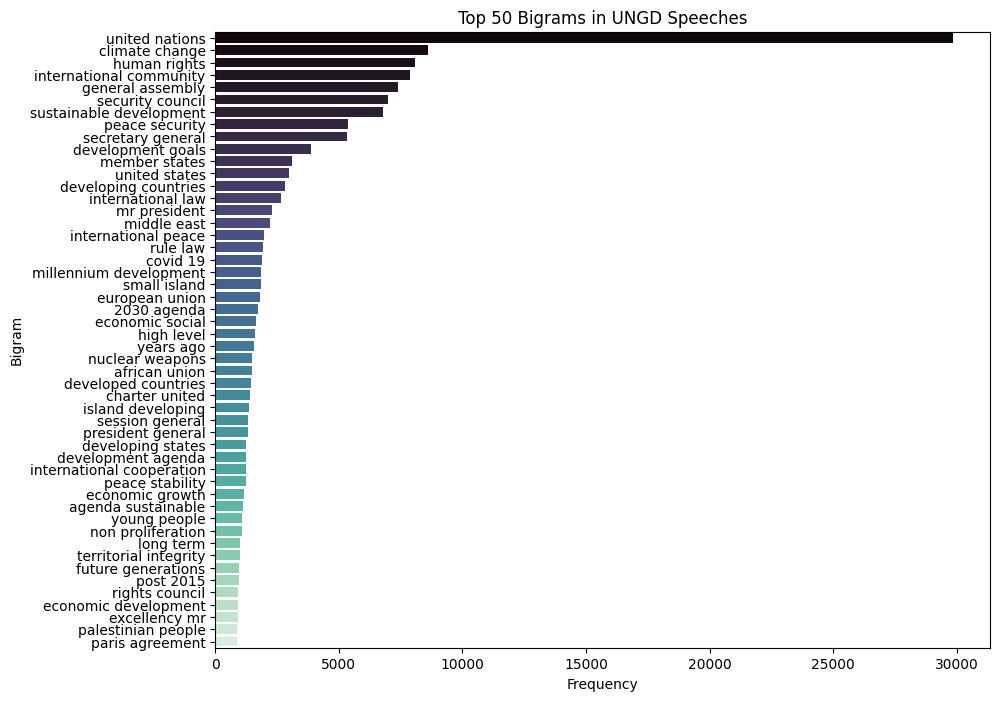

In [ ]:
# Top bigrams in the UNGD
bigram_vectorizer = CountVectorizer(stop_words='english', ngram_range=(2,2), min_df=5)
X_bigrams = bigram_vectorizer.fit_transform(ungdc_df['SpeechText'])

bigram_counts = X_bigrams.toarray().sum(axis=0)
bigram_vocab = bigram_vectorizer.get_feature_names_out()
bigram_freq_df = pd.DataFrame({'bigram': bigram_vocab, 'count': bigram_counts})
top50_bigrams = bigram_freq_df.sort_values(by='count', ascending=False).head(50)

plt.figure(figsize=(10,8))
sns.barplot(data=top50_bigrams, y='bigram', x='count', palette="mako")
plt.title("Top 50 Bigrams in UNGD Speeches")
plt.xlabel("Frequency")
plt.ylabel("Bigram")
plt.show()

**Observation:**

The most frequent unigrams highlight the institutional and thematic backbone of the UNGD, terms like nations, united, international, development, security, and peace dominating across years. A recurring emphasis on collective identity, governance, and global challenges. The bigram distribution adds further specificity: phrases such as united nations, climate change, human rights, and sustainable development stand out, alongside institutional references like security council and general assembly. Together, these patterns show how discourse balances procedural framework with policy priorities, particularly development, rights, and international cooperation.

##**Do economic conditions influence the rhetorical priorities of speeches?**

  Econ_Regime  Count
0      Upturn   2298
1    Downturn    799


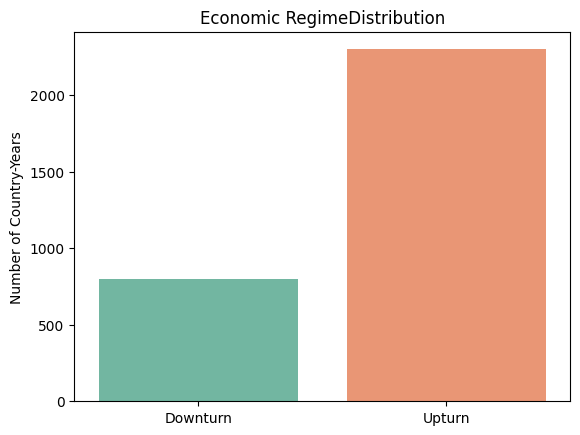

In [ ]:
# GDP growth and regime classification
ungdc_df = ungdc_df.sort_values(['ISO','Year']).copy()
ungdc_df['GDP_growth'] = ungdc_df.groupby('ISO')['GDP'].pct_change() * 100

def map_regime(g):
    if pd.isna(g): return None
    if g <= 0: return "Downturn"
    elif g > 0: return "Upturn"

ungdc_df['Econ_Regime'] = ungdc_df['GDP_growth'].apply(map_regime)

# Class balance
regime_counts = ungdc_df['Econ_Regime'].value_counts().reset_index()
regime_counts.columns = ['Econ_Regime','Count']
print(regime_counts)

sns.barplot(data=regime_counts, x='Econ_Regime', y='Count', order=['Downturn','Upturn'], palette='Set2')
plt.title("Economic RegimeDistribution")
plt.ylabel("Number of Country-Years")
plt.xlabel("")
plt.show()

In [ ]:
# Subset speeches delivered during economic downturns and upturns
df = (ungdc_df.loc[ungdc_df['Econ_Regime'].isin(['Downturn','Upturn'])].dropna(subset=['SpeechText']).copy())
df['Regime_bin'] = df['Econ_Regime']

# Features, targets, grouping
X_text = df['SpeechText']
y_bin  = df['Regime_bin']
groups = df['ISO']


# Custom UN stopwords
custom_un_stops = {
    "president", "assembly", "session", "council", "nations", "united",
    "state", "states", "general", "excellency", "honourable", "distinguished",
    "delegates", "gentlemen", "ladies", "chair", "statement", "address", "today",
    "like", "people", "world", "country", "countries", "year", "years", "excellencies",
    "mr", "announced", "age", "thank", "09", "19", "75", "75th", "06", "11", "sixth"
}
STOPWORDS_LIST = list(set(ENGLISH_STOP_WORDS).union(custom_un_stops))

# Hold out test set by country
iso_train, iso_test = train_test_split(df['ISO'].unique(), test_size=0.2, random_state=42)
mask_test = df['ISO'].isin(iso_test)

X_train, X_test = X_text[~mask_test], X_text[mask_test]
y_train_bin, y_test_bin = y_bin[~mask_test], y_bin[mask_test]
groups_train = groups[~mask_test]

# Pipeline: TF-IDF vectorizaiton then Linear SVM
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        stop_words=STOPWORDS_LIST,
        ngram_range=(1,2),
        min_df=5,
        max_df=0.9,
        sublinear_tf=True
    )),
    ("clf", LinearSVC(class_weight='balanced'))
])

# Hyperparameters to tune
param_grid = {
    "tfidf__ngram_range": [(1,1), (1,2), (1,3)],
    "tfidf__min_df": [3, 5, 10],
    "clf__C": [0.25, 0.5, 1, 2]}

# CV grouped by country
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

gs = GridSearchCV(
    pipe,
    param_grid,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1,
)

# Fit and evaluation
gs.fit(X_train, y_train_bin, groups=groups_train)
print("Best params:", gs.best_params_)
print("CV macro-F1:", gs.best_score_)

y_pred = gs.predict(X_test)
print(classification_report(y_test_bin, y_pred, digits=3))
print(confusion_matrix(y_test_bin, y_pred))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best params: {'clf__C': 0.25, 'tfidf__min_df': 10, 'tfidf__ngram_range': (1, 2)}
CV macro-F1: 0.6496113066124751
              precision    recall  f1-score   support

    Downturn      0.524     0.350     0.420       123
      Upturn      0.853     0.923     0.887       504

    accuracy                          0.810       627
   macro avg      0.689     0.636     0.653       627
weighted avg      0.789     0.810     0.795       627

[[ 43  80]
 [ 39 465]]


**Explanation:**

Using a supervised classification model speeches were differentiated by economic downturns and upturns.  Data was split at the country level so that no country contributed to both sets, cross-validation followed the same rule to ensure independence between training and evaluation.

A custom stopword list is introduced to filter out ceremonial and institutional vocabulary that is frequent across all years but does not provide signals for distinguishing economic regimes. Terms such as president, assembly, session, excellency, and numeric references to anniversaries or meeting counts are diplomatic protocol rather than economic context. Removing them reduces noise and allows the model to emphasize substantive economic language.

The analytical pipeline applies TF-IDF vectorization with unigrams and bigrams, incorporating frequency thresholds to exclude both rare and overly common terms. Sublinear term weighting is used to dampen the influence of repetition. A linear Support Vector Machine serves as the classifier, with class weights balanced to address uneven class distributions. Hyperparameters for the vectorizer and the penalty term are tuned through grid search, using macro F1 as the optimization metric to balance performance across regimes. Model evaluation is performed on held-out test countries, with results reported through precision, recall, and confusion matrices.

**Observation:**

The tuned model achieves an overall accuracy of 0.81, but performance is uneven across classes. Upturn speeches are identified with relative ease, while downturn speeches remain difficult to detect, with recall dropping to 0.35. The macro F1 score of 0.65 reflects this imbalance by weighting performance equally across both classes. The confusion matrix shows that many downturn speeches are misclassified as upturns, indicating that although the model captures general economic discourse effectively, the language of downturns is expressed more subtly and with greater variation, making it harder to distinguish.

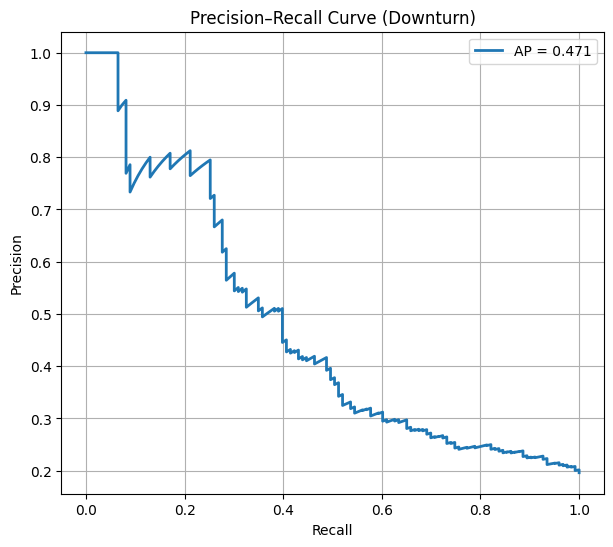

In [ ]:
# Precision recall for downturn
precision, recall, thresholds = plot_pr_curve(gs.best_estimator_, X_test, y_test_bin)

**Observation:**

The curve shows that downturn identification is challenging: precision drops rapidly as recall increases, suggesting that the model can identify some downturns with high confidence but struggles to sustain accuracy as coverage expands. The AP of 0.47 confirms that the signal for downturn language is present but weak. This pattern aligns with the earlier confusion matrix, where many downturns were misclassified as upturns, highlighting the subtle and inconsistent rhetorical cues that characterize economic downturn speeches.

In [ ]:
# Threshold tuning for Downturn vs Upturn classification
svm = gs.best_estimator_
m = svm.decision_function(X_test)

downturn_idx = list(svm.named_steps['clf'].classes_).index('Downturn')
if downturn_idx == 0: scores = -m
else: scores = m

# Sweep thresholds and pick best tradeoff
ths = np.percentile(scores, np.linspace(5, 95, 15))
best = None
for t in ths:
    y_hat = np.where(scores >= t, 'Downturn', 'Upturn')
    rpt = classification_report(y_test_bin, y_hat, output_dict=True, zero_division=0)
    rec = rpt['Downturn']['recall']; prec = rpt['Downturn']['precision']
    if prec >= 0.40:
        if best is None or rec > best[0]:
            best = (rec, prec, t, rpt['accuracy'])

print("Best threshold:", best)

Best threshold: (0.4065040650406504, 0.44642857142857145, -0.09346736397102233, 0.784688995215311)


**Explanation:**

Varying the decision threshold on SVM scores allows the model to achieve a more effective balance between precision and recall specifically for the downturn classification. By sweeping thresholds rather than using the default boundary, the evaluation identifies a setting that improves recall while maintaining precision.

**Observation:**

The best threshold achieved a downturn recall of 0.41 with precision near 0.45, and an accuracy of 0.78. Overall accuracy is slightly lower than at the default threshold, the adjustment improves the ability to detect downturns without sacrificing precision. A trade-off that allows the model to better capture minority class patterns that standard decision boundaries overlook at the cost of a modest reduction in aggregate accuracy.

In [ ]:
# Evaluate model using the tuned decision threshold
t_star = best[2]
y_pred_thr = np.where(scores >= t_star, 'Downturn', 'Upturn')
print(classification_report(y_test_bin, y_pred_thr, digits=3))

              precision    recall  f1-score   support

    Downturn      0.446     0.407     0.426       123
      Upturn      0.858     0.877     0.868       504

    accuracy                          0.785       627
   macro avg      0.652     0.642     0.647       627
weighted avg      0.777     0.785     0.781       627



**Observation:**

The tuned threshold produces more balanced performance across classes, raising recall for downturn speeches to 0.41 while keeping precision at 0.45. Upturn classification remains strong, with precision and recall both above 0.85. The macro F1 score of 0.65 shows that improvements for the minority class.

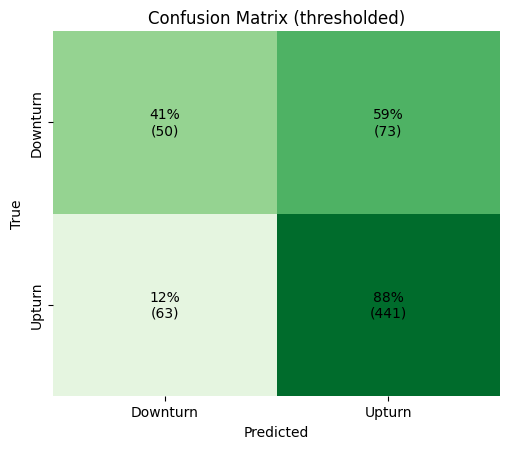

In [ ]:
# Tuned thresholded predictions
scores = gs.decision_function(X_test)

clf = gs.best_estimator_.named_steps["clf"]
cls = list(clf.classes_)

if cls[1] == "Downturn":
    pos_scores = scores
else:
    pos_scores = -scores

best_thresh = -0.095
y_pred_thresh = np.where(pos_scores >= best_thresh, "Downturn", "Upturn")

# Confusion matrix
labels = ["Downturn", "Upturn"]
cm_counts = confusion_matrix(y_test_bin, y_pred_thresh, labels=labels)
cm_perc = cm_counts.astype(float) / cm_counts.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(figsize=(5.2, 4.6))
sns.heatmap(cm_perc, annot=False, cmap="Greens", vmin=0, vmax=1, cbar=False, ax=ax,
    xticklabels=labels, yticklabels=labels)

for i in range(cm_counts.shape[0]):
    for j in range(cm_counts.shape[1]):
        ax.text(
            j + 0.5, i + 0.5,
            f"{cm_perc[i, j]*100:.0f}%\n({cm_counts[i, j]})",
            ha="center", va="center", fontsize=10, color="black"
        )

ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix (thresholded)")
plt.tight_layout()
plt.show()

**Observation:**

The confusion matrix highlights the persistent asymmetry: downturns are still more often misclassified as upturns, but the adjustment ensures that a larger share of true downturns are now captured. Importantly, the strong performance on upturn speeches is maintained, with nearly nine in ten correctly classified. This indicates that while the model still struggles with the minority class, the threshold tuning creates a more meaningful signal for downturns without undermining the reliability of upturn detection.

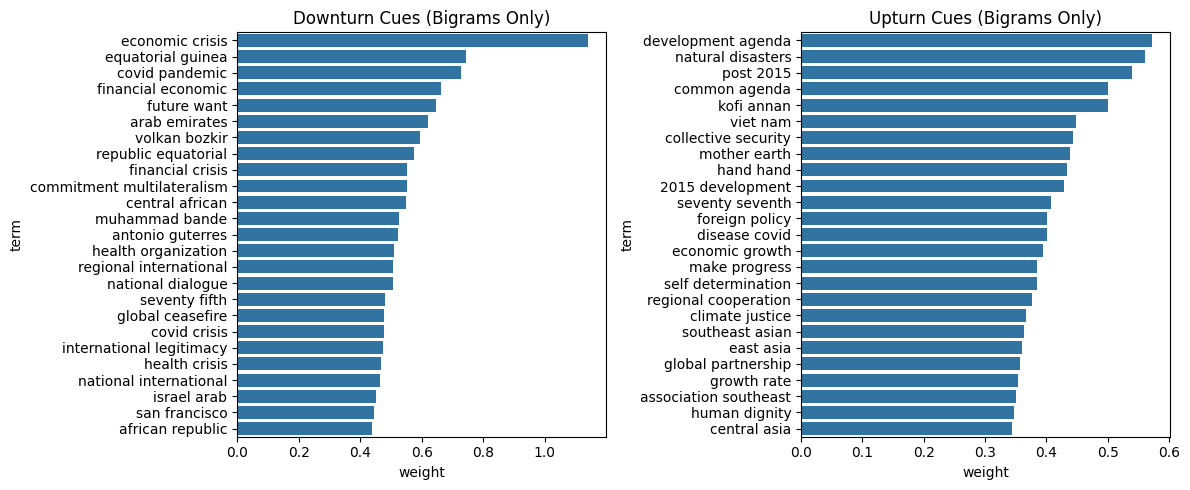

In [ ]:
# Force a bigram only vectorizer using the same stopwords
bigram_vec = TfidfVectorizer(
    lowercase=True,
    stop_words=STOPWORDS_LIST,
    ngram_range=(2,2),    # <-- only bigrams
    min_df=5,
    max_df=0.9,
    sublinear_tf=True
)

# Refit the vectorizer on the training set
X_train_big = bigram_vec.fit_transform(X_train)
clf = LinearSVC(C=0.25, class_weight="balanced")  # same params as best grid
clf.fit(X_train_big, y_train_bin)

features_big = bigram_vec.get_feature_names_out()
coefs_big = clf.coef_.ravel()

# Map weights to classes
if clf.classes_[1] == "Upturn":
    weights_up = coefs_big
    weights_down = -coefs_big
else:
    weights_down = coefs_big
    weights_up = -coefs_big

# Extract top bigrams
def top_k(features, weights, k=25):
    idx = np.argsort(weights)[-k:][::-1]
    return pd.DataFrame({"term": features[idx], "weight": weights[idx]})

top_down_big = top_k(features_big, weights_down)
top_up_big   = top_k(features_big, weights_up)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.barplot(data=top_down_big, x="weight", y="term", ax=axes[0])
axes[0].set_title("Downturn Cues (Bigrams Only)")
sns.barplot(data=top_up_big, x="weight", y="term", ax=axes[1])
axes[1].set_title("Upturn Cues (Bigrams Only)")
plt.tight_layout()
plt.show()

**Explanation:**

Limiting the vectorizer to bigrams emphasizes paired terms that provide stronger contextual cues than single words, highlighting combinations most indicative of downturn or upturn rhetoric. The resulting feature weights reveal language patterns such as economic phrases or institutional references that go beyond general vocabulary, capturing directional signals about underlying conditions.

**Observation:**

The bigram cues highlight a decisive linguistic split between downturn and upturn contexts. Downturn speeches are anchored in crisis oriented terminology, with expressions such as economic crisis, covid pandemic, and financial crisis capturing moments of instability and collective vulnerability.

Upturn language centers on growth, cooperation, and institutional agendas, with cues like development agenda, economic growth, and regional cooperation pointing toward stability and forward looking objectives. This divergence shows that the distinction between downturns and upturns is not simply a matter of sentiment strength, but is embedded in how states frame economic conditions through paired terms. The presence of these collocations provides the underlying regime, offering both interpretability and validation that rhetorical framing aligns closely with economic conditions.

##**How global economic shocks reflected in the collective UN discourse?**

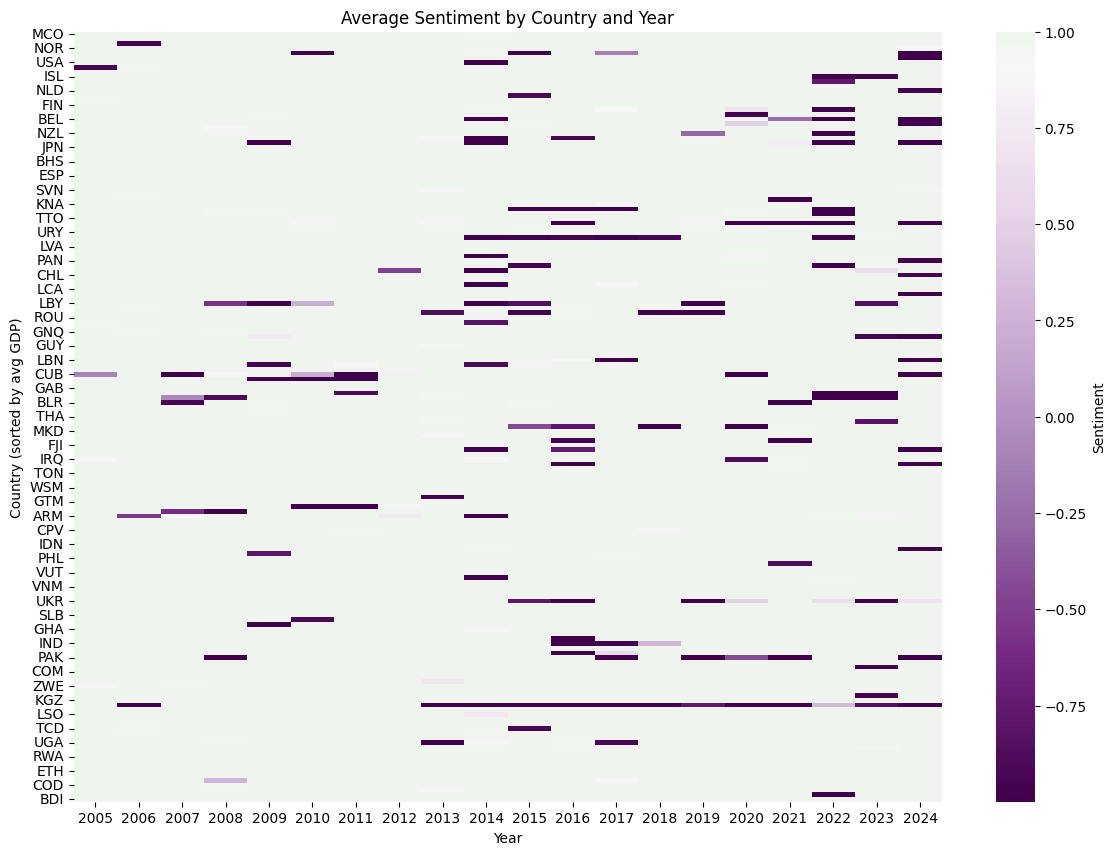

In [ ]:
# Country by year sentiment matrix
sent_matrix = (ungdc_df.groupby(['ISO','Year'])['Sentiment'].mean().reset_index()
    .pivot(index='ISO', columns='Year', values='Sentiment'))

# Each country average GDP across years
avg_gdp = ungdc_df.groupby('ISO')['GDP'].mean()
row_order = avg_gdp.sort_values(ascending=False).index

plt.figure(figsize=(14,10))
sns.heatmap(sent_matrix.loc[row_order], cmap="PRGn", center=0.9, cbar_kws={'label':'Sentiment'})

plt.title("Average Sentiment by Country and Year")
plt.ylabel("Country (sorted by avg GDP)")
plt.xlabel("Year")
plt.show()

**Observation:**

The heatmap shows that collective sentiment shifts during major global shocks, with dips around the financial crisis, geopolitical conflicts, and COVID-19. While the response is not perfectly consistent across countries or years, there is a clear pattern of disruption where sentiment becomes more negative during these periods. The effect is particularly visible among upper and middle income countries, where speeches show stronger swings toward negative sentiment compared to lower-income peers.

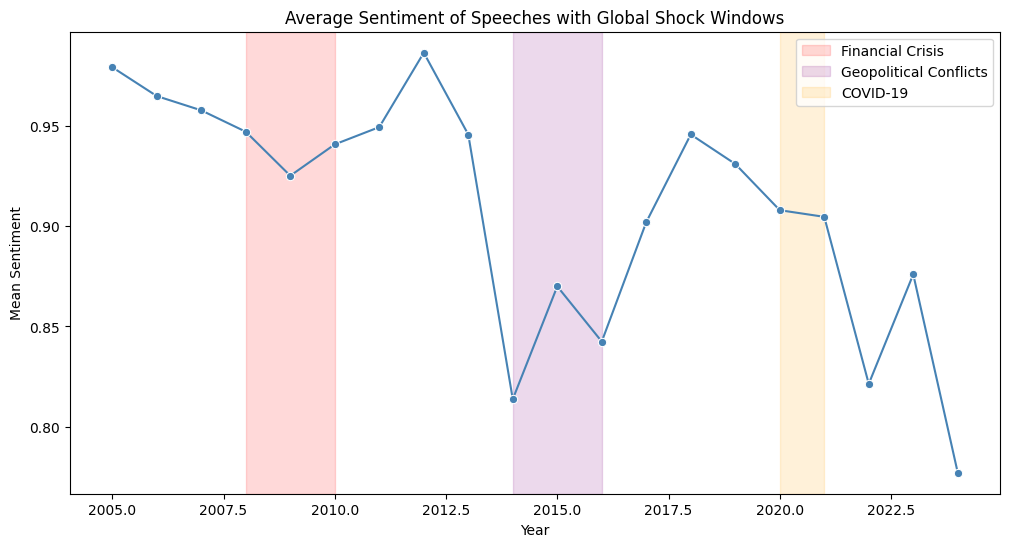

In [ ]:
# Yearly sentiment trend with shock periods highlighted
sent_trend = (ungdc_df.groupby("Year")["Sentiment"].mean().reset_index())

plt.figure(figsize=(12,6))
sns.lineplot(data=sent_trend, x='Year', y='Sentiment', marker='o', color='steelblue')

plt.axvspan(2008, 2010, color='red', alpha=0.15, label="Financial Crisis")
plt.axvspan(2014, 2016, color='purple', alpha=0.15, label="Geopolitical Conflicts")
plt.axvspan(2020, 2021, color='orange', alpha=0.15, label="COVID-19")

plt.title("Average Sentiment of Speeches with Global Shock Windows")
plt.ylabel("Mean Sentiment")
plt.xlabel("Year")
plt.legend()
plt.show()

**Observation:**

The trend line shows that average sentiment declines during periods marked by global shocks, with noticeable dips around the financial crisis, geopolitical conflicts, and COVID-19. While sentiment generally recovers after each event, the downturns highlight the disruptive effect of crises on the tone of the collective UN speeches. The pattern suggests that shocks consistently reduce optimism in discourse, even if the timing and depth of these declines vary.

In [ ]:
# Define time windows for major global shocks
shock_periods = {
    "Financial Crisis": (2008, 2010),
    "Geopolitical Conflicts": (2014, 2016),
    "COVID-19": (2020, 2021)}

# Return speeches within a given year range
def get_window_texts(df, start, end):
    return df.loc[df["Year"].between(start, end) & df["SpeechText"].notna()].copy()

window_data = {name: get_window_texts(ungdc_df, s, e) for name, (s, e) in shock_periods.items()}
{k: v.shape for k, v in window_data.items()}

{'Financial Crisis': (489, 12),
 'Geopolitical Conflicts': (489, 12),
 'COVID-19': (326, 12)}

**Explanation:**

Time windows are established to isolate periods of the global shocks, speeches are collected into focused subsets, this enables direct comparison of discourse across crises by ensuring that only relevant years are included.

In [ ]:
# Fit LDA topic models for each shock period
shock_outputs = {}

for name, dfw in window_data.items():
    texts = dfw["SpeechText"].tolist()
    tokens = preprocess_docs(texts)
    lda, dictionary, corpus, grid = fit_lda_with_coherence(tokens, k_grid=(6,8,10,12,14))
    shock_outputs[name] = {"tokens": tokens, "lda": lda, "dictionary": dictionary, "corpus": corpus, "grid": grid}
    print(f"\n{name}: best k = {lda.num_topics}")
    print_topics_readable(lda, topn=12)


Financial Crisis: best k = 6
Topic 00: somalia, china, israel, turkey, conflict, terrorism, yemen, pakistan, will_continue, asean, prosperity, middle_east
Topic 01: justice, georgia, nepal, god, freedom, free, those_who, history, long, come, democracy, solidarity
Topic 02: women, member_states, africa, conflict, european_union, conference, implementation, resolution, welcome, particularly, negotiations, democratic
Topic 03: africa, per_cent, food, trade, energy, economy, assistance, provide, food_crisis, economies, food_security, small
Topic 04: terrorism, responsibility, energy, believe_that, afghanistan, democracy, nation, let, principles, nuclear, face, clear
Topic 05: iraq, united_states, israel, arab, resolutions, rights, war, right, lebanon, solution, middle_east, terrorism

Geopolitical Conflicts: best k = 8
Topic 00: europe, refugees, international_law, crisis, values, challenge, education, syria, let, respect_for, strong, history
Topic 01: africa, african, democracy, per_cent

**Explanation:**

Topic models are trained separately for each shock period to identify the thematic structure. Speeches are cleaned and tokenized, and candidate models with varying topic numbers are fit and evaluated using coherence to ensure that the resulting themes are interpretable and distinct. This approach is particularly effective for a corpus of this scale and diversity, as it reduces unstructured political text into a set of latent themes that reveal recurring patterns without relying on predefined dictionaries. Running models by shock period makes it possible to compare how thematic emphasis shifts during crises, capturing both the persistence of baseline concerns and the emergence of new priorities in response to global events.

**Observation:**

The topic models highlight how global shocks shape UN discourse in distinct ways. During the financial crisis, themes center on food security, economic stability, and terrorism, with repeated references to Iraq and the Middle East. In the geopolitical conflict period, discourse expands to include refugees, international law, regional crises in Syria and Ukraine, and debates around democracy and reform. The COVID-19 window shifts attention toward vaccines, public health, climate recovery, and global solidarity, while still tying into broader humanitarian and political concerns. Across all periods, enduring issues such as security, international law, and Middle East conflicts remain present, but the emergence of new topics within each window illustrates how the agenda includes current global disruptions.

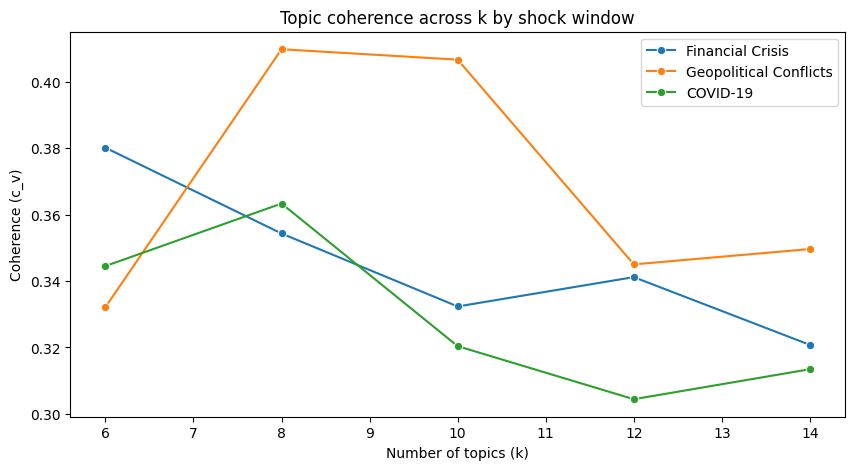

In [ ]:
# Plot coherence scores across different topic numbers for each shock period
plt.figure(figsize=(10,5))
for name, out in shock_outputs.items():
    g = out["grid"].sort_values("k")
    sns.lineplot(data=g, x="k", y="coherence", marker="o", label=name)
plt.title("Topic coherence across k by shock window")
plt.xlabel("Number of topics (k)"); plt.ylabel("Coherence (c_v)")
plt.legend(); plt.show()

**Observation:**

The coherence comparison highlights variation in how well topics form across crises. The financial crisis reaches its highest coherence at 6 before steadily declining, indicating a relatively compact thematic structure. COVID-19 shows a similar peak at 8 topics, though with generally lower coherence values, more diffuse or overlapping themes. Geopolitical conflicts stand out with the highest coherence overall, peaking strongly at 8 topics, which reflects conflict related rhetoric is in more distinct clusters. Taken together, the curves show that optimal topic structure differs across crises, with some producing sharper thematic separation than others.

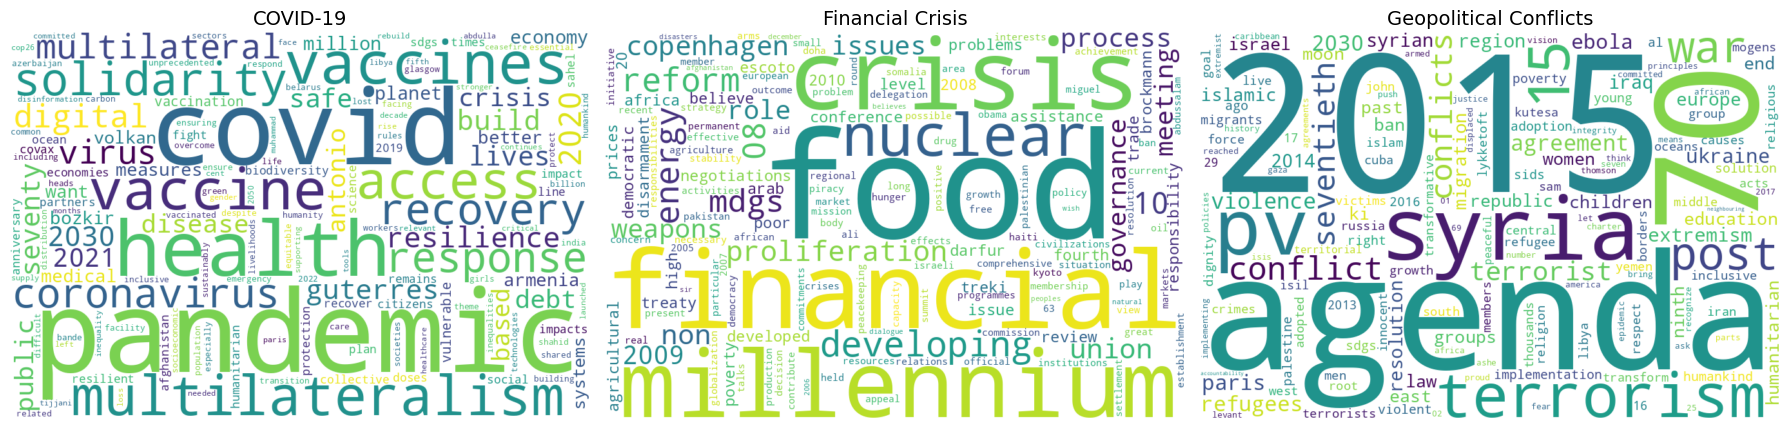

In [ ]:
# Generate word clouds showing distinct vocabulary for each shock period
all_docs, labels = [], []
for window, dfw in window_data.items():
    for t in dfw["SpeechText"].dropna():
        all_docs.append(t)
        labels.append(window)

vectorizer = CountVectorizer(stop_words=STOPWORDS_LIST, min_df=5, max_df=0.7)
X = vectorizer.fit_transform(all_docs)
terms = np.array(vectorizer.get_feature_names_out())

doc_df = pd.DataFrame(X.toarray(), columns=terms)
doc_df["Window"] = labels
avg = doc_df.groupby("Window").mean()
avg = avg.div(avg.sum(axis=1), axis=0)

distinct = {}
for w in avg.index:
    this = avg.loc[w].values
    others = avg.drop(w).mean().values
    diff = this - others
    scores = pd.Series(diff, index=terms).clip(lower=0)
    distinct[w] = scores.sort_values(ascending=False).head(150)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for ax, (w, weights) in zip(axes, distinct.items()):
    wc = WordCloud(width=900, height=600, background_color="white")
    wc.generate_from_frequencies(weights.to_dict())
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(f"{w}", fontsize=14)

plt.tight_layout()
plt.show()

**Observation:**

The COVID-19 period was defined by urgent health and solidarity themes, with pandemic, covid, vaccine, and health overwhelmingly present, capturing the global nature of the crisis and the demand for collective response.

The Financial Crisis vocabulary is centered on economic hardship and institutional frameworks, with terms such as financial, crisis, food, and millennium reflecting concern with stability and development agendas.

The Geopolitical Conflicts window emphasized conflict and instability, dominated by words like war, refugees, terrorism, Syria, and post 2015 agenda, pointing to overlapping humanitarian and security challenges alongside long-term planning.

The patterns confirm that global shocks leave strong imprints on diplomatic language, with each crisis marked by a vocabulary shift toward its defining concerns.

In [ ]:
# Define non shock years
nonshock_df = ungdc_df.loc[~(
        (ungdc_df["Year"].between(2008,2010)) |
        (ungdc_df["Year"].between(2014,2016)) |
        (ungdc_df["Year"].between(2020,2021)))].dropna(subset=["SpeechText"]).copy()
nonshock_tokens = preprocess_docs(nonshock_df["SpeechText"].tolist())

# Fit LDA and sweep for best k
lda_ns, dict_ns, corp_ns, grid_ns = fit_lda_with_coherence(nonshock_tokens, k_grid=(8,10,12,14))

print("Best k for non-shock =", lda_ns.num_topics)
print_topics_readable(lda_ns, topn=12)

Best k for non-shock = 10
Topic 00: women, war, climate, let, per_cent, want, democracy, ukraine, freedom, know, history, responsibility
Topic 01: war, international_law, turkey, viet_nam, bolivia, cyprus, guatemala, namibia, per_cent, africa, life, humankind
Topic 02: kazakhstan, tajikistan, afghanistan, thailand, ukraine, water, resolution, effective, area, european_union, problems, republic_moldova
Topic 03: sudan, somalia, republic, burundi, congo, arab, agreement, initiative, africa, context, african_union, central_african
Topic 04: africa, women, summit, millennium_development, developing_countries, effective, japan, democracy, particular, welcome, high_level, rule_law
Topic 05: bosnia, herzegovina, democracy, war, per_cent, life, planet, citizens, history, justice, those_who, humankind
Topic 06: climate, small_island, sustainable, developing_states, sids, developing_countries, partners, health, financing, caribbean, small, community
Topic 07: israel, war, iran, syria, iraq, free

**Observation:**

Non-shock years were also isolated to construct a baseline corpus against which shock windows can be compared. Topics reveal a broad and balanced agenda, reflecting recurring UNGD concerns rather than crisis driven rhetoric. Themes center on democracy, international law, conflict resolution, and climate change, alongside strong emphasis on Africa, small island states, and development partnerships. References to specific countries and regions are dispersed, signaling ongoing diplomatic engagement rather than concentrated geopolitical crises.

In [ ]:
# Topic Model labels (granular)
granular_labels = {
    "Financial Crisis": {
        0: "Middle East conflicts & terrorism",
        1: "Democracy, justice & solidarity",
        2: "UN process: resolutions & negotiations",
        3: "Food/Energy/Economy crisis",
        4: "Global security: terrorism/Afghanistan/nuclear",
        5: "Iraq/Israel–Lebanon: war, rights, resolutions"
    },
    "Geopolitical Conflicts": {
        0: "Refugees & international law (Europe/Syria)",
        1: "Africa: democracy, reform, health, education",
        2: "Yemen: militias, coup, constitution",
        3: "Israel–Palestine: justice, religion",
        4: "Ukraine–Russia: sovereignty & trade",
        5: "Syria/Libya/Iraq: sovereignty & occupation",
        6: "Iran & broader Middle East crises",
        7: "SIDS & climate (Pacific/oceans)"
    },
    "COVID-19": {
        0: "Rights & vaccines (children/humanitarian)",
        1: "Debt/finance & vaccine equity (India/global)",
        2: "Africa: poverty & security",
        3: "Climate & recovery (SDGs, small islands)",
        4: "Arab world conflicts & humanitarian",
        5: "Turkey/territories: military & international law",
        6: "Global solidarity & humankind",
        7: "International law, justice & citizens"
    },
    "Non-Shock": {
        0: "Women/democracy & emerging climate concerns",
        1: "International law & human dignity",
        2: "Central Asia/Eastern Europe water/sovereignty",
        3: "African conflicts & peace agreements",
        4: "African development & governance (MDGs)",
        5: "Democracy & post-conflict justice",
        6: "Climate & sustainability (SIDS, financing)",
        7: "Middle East conflict & sovereignty",
        8: "African democracy & solidarity",
        9: "Small islands & regional identities"
    }
}

# Topic maping (broad)
broad_map = {
    "Financial Crisis": {
        0: "Wars & Security",
        1: "Democracy & Human Rights",
        2: "Sovereignty & International Order",
        3: "Global Economy",
        4: "Wars & Security",
        5: "Wars & Security"
    },
    "Geopolitical Conflicts": {
        0: "Refugees & Humanitarian Issues",
        1: "African Development & Governance",
        2: "Wars & Security",
        3: "Border & Territorial Disputes",
        4: "Border & Territorial Disputes",
        5: "Wars & Security",
        6: "Wars & Security",
        7: "Climate Change & Small Islands"
    },
    "COVID-19": {
        0: "Global Health & Solidarity",
        1: "Global Health & Solidarity",
        2: "African Development & Governance",
        3: "Climate Change & Small Islands",
        4: "Wars & Security",
        5: "Wars & Security",
        6: "Global Health & Solidarity",
        7: "Wars & Security"
    },
    "Non-Shock": {
        0: "Democracy & Human Rights",
        1: "Democracy & Human Rights",
        2: "Border & Territorial Disputes",
        3: "African Development & Governance",
        4: "African Development & Governance",
        5: "Democracy & Human Rights",
        6: "Climate Change & Small Islands",
        7: "Border & Territorial Disputes",
        8: "African Development & Governance",
        9: "Climate Change & Small Islands"
    }
}


**Explanation:**

Creating both granular and broad topic labels allows analysis to operate at two complementary levels. The granular labels preserve detail and nuance, capturing the specific themes and contexts that emerge within each shock or non-shock period. The broad mapping, by contrast, consolidates these into higher level categories such as “Wars & Security” or “Climate Change & Small Islands,” enabling clearer comparison across periods and reducing complexity for interpretability.

In [ ]:
# Labeled topic summary for each window
fin_df   = topic_summary(shock_outputs["Financial Crisis"]["lda"],
                         shock_outputs["Financial Crisis"]["corpus"],
                         "Financial Crisis", granular_labels, broad_map)
geo_df   = topic_summary(shock_outputs["Geopolitical Conflicts"]["lda"],
                         shock_outputs["Geopolitical Conflicts"]["corpus"],
                         "Geopolitical Conflicts", granular_labels, broad_map)
cov_df   = topic_summary(shock_outputs["COVID-19"]["lda"],
                         shock_outputs["COVID-19"]["corpus"],
                         "COVID-19", granular_labels, broad_map)
ns_df    = topic_summary(lda_ns, corp_ns, "Non-Shock", granular_labels, broad_map)

all_topics_labeled = pd.concat([fin_df, geo_df, cov_df, ns_df], ignore_index=True)
all_topics_labeled[["window","topic_id","mean_prevalence","granular_label","broad_category","top_words"]]

,window,topic_id,mean_prevalence,granular_label,broad_category,top_words
0,Financial Crisis,2,0.318857,UN process: resolutions & negotiations,Sovereignty & International Order,"women, member_states, africa, conflict, europe..."
1,Financial Crisis,3,0.283169,Food/Energy/Economy crisis,Global Economy,"africa, per_cent, food, trade, energy, economy..."
2,Financial Crisis,4,0.185507,Global security: terrorism/Afghanistan/nuclear,Wars & Security,"terrorism, responsibility, energy, believe_tha..."
3,Financial Crisis,5,0.112263,"Iraq/Israel–Lebanon: war, rights, resolutions",Wars & Security,"iraq, united_states, israel, arab, resolutions..."
4,Financial Crisis,0,0.061493,Middle East conflicts & terrorism,Wars & Security,"somalia, china, israel, turkey, conflict, terr..."
5,Financial Crisis,1,0.038711,"Democracy, justice & solidarity",Democracy & Human Rights,"justice, georgia, nepal, god, freedom, free, t..."
6,Geopolitical Conflicts,0,0.273848,Refugees & international law (Europe/Syria),Refugees & Humanitarian Issues,"europe, refugees, international_law, crisis, v..."
7,Geopolitical Conflicts,1,0.224195,"Africa: democracy, reform, health, education",African Development & Governance,"africa, african, democracy, per_cent, reform, ..."
8,Geopolitical Conflicts,7,0.141409,SIDS & climate (Pacific/oceans),Climate Change & Small Islands,"small_island, sids, developing_states, climate..."
9,Geopolitical Conflicts,4,0.116822,Ukraine–Russia: sovereignty & trade,Border & Territorial Disputes,"ukraine, per_cent, russia, democracy, believe_..."


**Explanation:**

The labeled topic summaries consolidate results from each period into a comparable format. Each topic is assigned granular and broad categories, along with its mean prevalence across speeches.

**Observation:**

Patterns show that crises shift the distribution of topics toward urgent concerns such as wars, sovereignty disputes, and global health, while non-shock years highlight broader governance, democracy, and sustainability themes. The structure demonstrates how moments of disruption compress discourse into narrower sets of urgent priorities, whereas calmer periods accommodate a wider thematic spread.

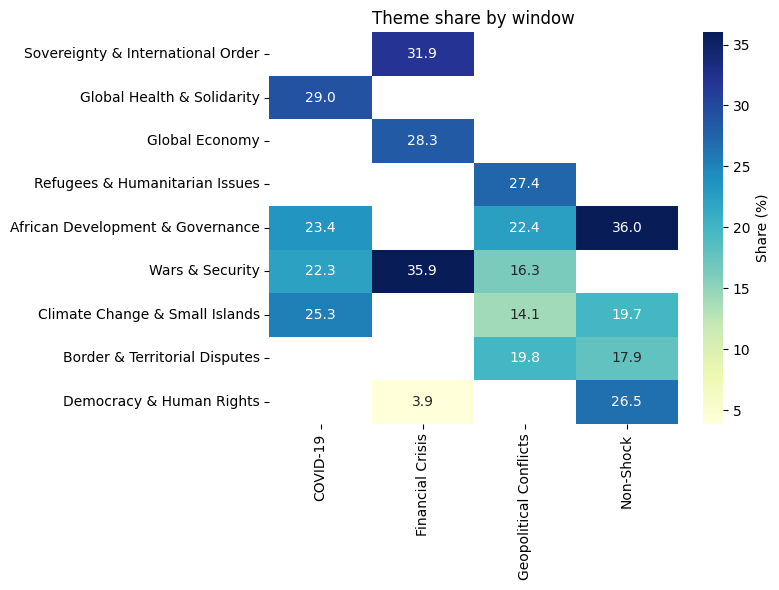

In [ ]:
# Summarize broad themes across shock vs non-shock periods by heatmap
def collapse_to_broad(df):
    g = df.groupby(["window","broad_category"], as_index=False)["mean_prevalence"].sum()
    g["share_%"] = (g["mean_prevalence"]*100).round(1)
    return g

broad_comp = collapse_to_broad(all_topics_labeled)
order = (broad_comp.groupby("broad_category")["share_%"]
         .mean().sort_values(ascending=False).index.tolist())

mat = broad_comp.pivot(index="broad_category", columns="window", values="share_%").reindex(order)
plt.figure(figsize=(8,6))
sns.heatmap(mat, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={"label":"Share (%)"})
plt.title("Theme share by window")
plt.xlabel(""); plt.ylabel("")
plt.tight_layout(); plt.show()

**Observation:**

The distribution highlights how global shocks shift the emphasis of UNGD discourse. The financial crisis window is dominated by security concerns and economic themes, while sovereignty and international order also rises sharply, reflecting instability. Geopolitical conflicts shift the balance toward humanitarian issues and territorial disputes, reducing attention to the economy. COVID-19 stands out with a surge in global health and solidarity, coupled with climate and development themes, marking a temporary reorientation of priorities. In contrast, non-shock periods show a more even distribution, with African governance and democracy occupying a larger share, suggesting that baseline debates return once acute crises resolve.

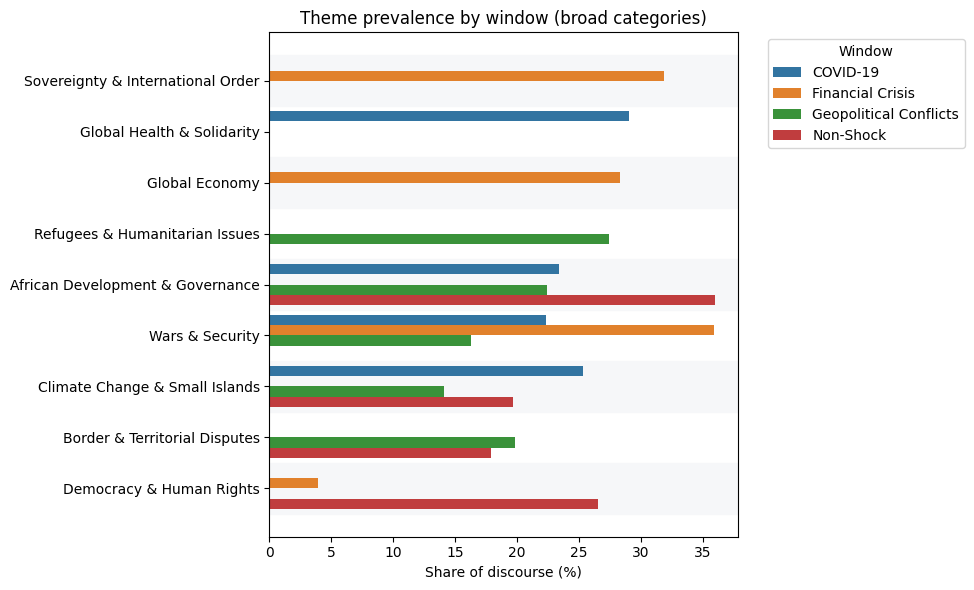

In [ ]:
# Theme prevalance across shock windows
plt.figure(figsize=(10,6))
ax = sns.barplot(data=broad_comp, y="broad_category", x="share_%", hue="window", orient="h", order=order)

for i, cat in enumerate(order):
    if i % 2 == 0:
        ax.axhspan(i-0.5, i+0.5, color="#f6f7f9", zorder=0)

plt.title("Theme prevalence by window (broad categories)")
plt.xlabel("Share of discourse (%)")
plt.ylabel("")
plt.legend(title="Window", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

**Observation:**

In non-shock years, themes are broadly distributed, reflecting a wide agenda. During crises, however, discourse contracts around fewer priorities. The financial crisis is dominated by global economy and wars and security, COVID-19 elevates global health and solidarity above all else, and geopolitical conflicts drive attention to refugees, humanitarian issues, and territorial disputes. The contrast underscores that moments of disruption do not just add urgency but reconfigure the thematic balance of debate, narrowing collective focus toward the issues most immediately at stake.

## **Conclusion**

The analysis demonstrates that the United Nations General Debate corpus provides a valuable lens for examining how economic cycles and global shocks reshape patterns of international discourse. At the level of economic regimes, supervised classification highlighted the asymmetry between upturn and downturn rhetoric, with upturns articulated in more consistent, easily detectable ways while downturns proved more fragmented and difficult to capture. At the level of systemic shocks, language and thematic emphasis did not simply intensify but shifted in composition, as collective attention narrowed around the current global issues. Taken together, these perspectives underscore how the UNGD forum reflects both the dynamics of the global economy and the unpredicted disruptions of crisis events.

The supervised classification of downturn and upturn rhetoric showed the difficulty of detecting downturns relative to upturns, the subtler, more fragmented ways in which negative conditions are articulated on the world stage. Precision-recall tradeoffs highlight that improving sensitivity to downturns requires sacrificing accuracy, a common characteristic of imbalanced corpus. Beyond predictive performance, the exercise illustrated that downturn discourse is more heterogeneous and often broadly positive or even aspirational language, reinforcing the challenge of extracting signals of distress from diplomatic speech.

The unsupervised topic modeling added a complementary layer by capturing thematic structures that emerge during specific crises. Coherence tuned models revealed that shocks like the financial crisis, geopolitical conflicts, and COVID-19 each produced distinct rhetorical traces, with emphasis shifting from economic security to humanitarian displacement to global health. Word cloud comparisons and bigram feature analysis further demonstrated how language adapts. This illustrates how shocks do not erase existing agendas but reconfigure them, pulling latent issues into sharper focus while temporarily suppressing others.

Confirmation that the UNGD's collective discourse both reflects and refracts the pressures of the global system. Economic shocks reorder priorities, sharpen attention, and elevate certain vocabularies, while still leaving traces of baseline concerns such as development, peace, and multilateralism. The combination of supervised and unsupervised approaches allowed the analysis to move beyond prediction into interpretation, providing insight into both the detectability of crisis rhetoric and the thematic shift that results. Ultimately, the UN General Debate reveals not only what states say, but how the international systems reorient under pressure, making discourse a vital signal of the collective world consciousness.